# Purpose:
- Calculate z-drift from multi-plane imaging data
    - Multiple configurations: 1x8, 2x4, and 4x2
- Compare the results across depths
- Also with x-y motion
- To check if online motion correction with the mean of all planes is good enough
- Requires the depth_estimation_module from brain_observatory_qc
    - Also from_lims and allensdk

In [1]:
import brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module as dem
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
from datetime import datetime
from matplotlib import pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims
from pymongo import MongoClient
import sys
sys.path.append(r'C:\Users\jinho.kim\Github\visual_behavior_analysis')
from visual_behavior import database as db

mongo = MongoClient('flaskapp.corp.alleninstitute.org', 27017)

save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')

In [2]:
def get_depth_region_from_db(oeid):
    query = '''
    SELECT oe.id, st.acronym, oe.calculated_depth, imd.depth
    FROM ophys_experiments oe
    JOIN structures st ON st.id = oe.targeted_structure_id
    JOIN imaging_depths imd ON imd.id = oe.imaging_depth_id
    WHERE oe.id = {}
    '''.format(oeid)
    lims_results = db.lims_query(query)
    return lims_results.depth.values[0], lims_results.acronym.values[0]


def get_zdrift_results(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
        
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids

def get_zdrift_results_first_last(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}_first_last.h5'
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids


## One example from 1x8 imaging data
- mouseID: 704576, session_id: 1330132892 (acquired 02/12/2024)


In [6]:
osid = 1330132892
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values


In [7]:

matched_plane_indices, corrcoef, segment_reg_imgs, \
        ref_oeid, ref_zstack_crop, rigid_tmat_list, translation_shift_list, ops = \
            dem.get_experiment_zdrift(oeids[0], ref_oeid=oeids[0], save_dir=save_dir)

# Select examples

In [7]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)

In [5]:
table.project_code.unique()

array(['VisualBehaviorMultiscope', 'LearningmFISHDevelopment', 'U01BFCT',
       'OpenScopeDendriteCoupling', 'VisualBehavior',
       'VisBIntTestDatacube', 'VisualBehaviorTask1B',
       'MultiscopeSignalNoise', 'omFISHRbp4Meso', 'LearningmFISHTask1A',
       'TaskTrainedNetworksMultiscope', 'omFISHGad2Meso',
       'VisualBehaviorMultiscope4areasx2d', 'omFISHSstMeso',
       'VipAxonalV1Phase1', 'MesoscopeDevelopment', 'omFISHCux2Meso',
       'VisualBehaviorIntegrationTest', 'VisualBehaviorDevelopment'],
      dtype=object)

In [7]:
table.query('project_code == "LearningmFISHTask1A"').targeted_structure.unique()

array(['VISp', 'VISam', 'VISal', 'VISl'], dtype=object)

In [10]:
table.query('project_code == "LearningmFISHTask1A" and targeted_structure == "VISl"').mouse_id.unique()

array(['639224', '612764', '646883', '633532', '636496', '616502',
       '617911', '616505', '608368', '624942', '603892', '629294'],
      dtype=object)

In [11]:
mids_config_4x2 = table.query('project_code == "LearningmFISHTask1A" and targeted_structure == "VISl"').mouse_id.unique()


In [13]:
np.setdiff1d(table.query('project_code == "LearningmFISHTask1A" and targeted_structure == "VISam"').mouse_id.unique(),
                mids_config_4x2)

array(['648606', '662253', '662491', '671833', '677594', '681417',
       '681721', '690308', '693545', '700387', '701050', '703340'],
      dtype=object)

In [14]:
mids_config_2x4 = np.setdiff1d(table.query('project_code == "LearningmFISHTask1A" and targeted_structure == "VISam"').mouse_id.unique(),
                            mids_config_4x2)

In [8]:
lamf_table = table.query('project_code == "LearningmFISHTask1A"')
lamf_table.groupby('mouse_id').apply(lambda x: len(x.targeted_structure.unique()))

mouse_id
603892    4
608368    4
612764    4
616502    4
616505    4
617911    4
624942    4
629294    4
633532    4
636496    4
639224    4
646883    4
648606    2
662253    2
662491    2
671833    2
677594    2
681417    2
681721    2
690308    2
693545    2
700387    2
701050    2
703340    2
704576    1
710343    1
711414    1
713835    1
717824    1
719374    1
dtype: int64

In [5]:
lamf_table.columns

Index(['equipment_name', 'donor_id', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'foraging_id',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_structure',
       'published_at', 'date_of_acquisition', 'session_type',
       'experience_level', 'passive', 'image_set'],
      dtype='object')

In [48]:
lamf_table.session_type.unique()

array(['TRAINING_1_gratings', 'TRAINING_0_gratings_autorewards_15min',
       'TRAINING_2_gratings_flashed', 'TRAINING_3_images_A_10uL_reward',
       'TRAINING_4_images_A_training', 'TRAINING_5_images_A_epilogue',
       'OPHYS_1_images_A', 'OPHYS_4_images_B', 'OPHYS_6_images_B',
       'TRAINING_5_images_A_handoff_ready'], dtype=object)

In [49]:
num_targeted_structure = lamf_table.groupby('mouse_id').apply(lambda x: len(x.targeted_structure.unique()))

min_num_sessions = 5

mids_config_4x2 = num_targeted_structure[num_targeted_structure == 4].index.values
num_sessions_within_mids = lamf_table[lamf_table.mouse_id.isin(mids_config_4x2)].groupby('mouse_id').apply(lambda x: len(x[~x.session_type.str.contains('TRAINING_0_')].ophys_session_id.unique()))
mids_config_4x2_final = num_sessions_within_mids[num_sessions_within_mids > min_num_sessions].index.values[-5:]

mids_config_2x4 = num_targeted_structure[num_targeted_structure == 2].index.values
num_sessions_within_mids = lamf_table[lamf_table.mouse_id.isin(mids_config_2x4)].groupby('mouse_id').apply(lambda x: len(x[~x.session_type.str.contains('TRAINING_0_')].ophys_session_id.unique()))
mids_config_2x4_final = num_sessions_within_mids[num_sessions_within_mids > min_num_sessions].index.values[-5:]

mids_config_1x8 = num_targeted_structure[num_targeted_structure == 1].index.values
num_sessions_within_mids = lamf_table[lamf_table.mouse_id.isin(mids_config_1x8)].groupby('mouse_id').apply(lambda x: len(x[~x.session_type.str.contains('TRAINING_0_')].ophys_session_id.unique()))
mids_config_1x8_final = num_sessions_within_mids[num_sessions_within_mids > min_num_sessions].index.values

print(f'{len(mids_config_4x2_final)} mice from 4x2')
print(f'{len(mids_config_2x4_final)} mice from 2x4')
print(f'{len(mids_config_1x8_final)} mice from 1x8')


5 mice from 4x2
5 mice from 2x4
3 mice from 1x8


In [58]:
# select random 3 sessions from 5 mice for each configuration
# - 3 mice for 1x8
num_selection = 3
multiplane_zdrift_osids = pd.DataFrame(columns=['mouse_id', 'ophys_session_id', 'config'])
select_session_type_table = lamf_table[~(lamf_table.session_type.str.contains("TRAINING_0_"))]
for mid in mids_config_4x2_final:
    temp_table = select_session_type_table[select_session_type_table.mouse_id == mid]
    osids = np.random.choice(temp_table.ophys_session_id.unique(), num_selection, replace=False)
    for osid in osids:
        temp_df = pd.DataFrame({'mouse_id': mid, 'ophys_session_id': osid, 'config': '4x2',
                                'session_type': lamf_table.query('ophys_session_id == @osid').session_type.unique()},
                                index=[0])
        multiplane_zdrift_osids = pd.concat([multiplane_zdrift_osids, temp_df], ignore_index=True)
for mid in mids_config_2x4_final:
    temp_table = select_session_type_table[select_session_type_table.mouse_id == mid]
    osids = np.random.choice(temp_table.ophys_session_id.unique(), num_selection, replace=False)
    for osid in osids:
        temp_df = pd.DataFrame({'mouse_id': mid, 'ophys_session_id': osid, 'config': '2x4',
                                'session_type': lamf_table.query('ophys_session_id == @osid').session_type.unique()},
                                index=[0])
        multiplane_zdrift_osids = pd.concat([multiplane_zdrift_osids, temp_df], ignore_index=True)
for mid in mids_config_1x8_final:
    temp_table = select_session_type_table[select_session_type_table.mouse_id == mid]
    osids = np.random.choice(temp_table.ophys_session_id.unique(), num_selection, replace=False)
    for osid in osids:
        temp_df = pd.DataFrame({'mouse_id': mid, 'ophys_session_id': osid, 'config': '1x8',
                                'session_type': lamf_table.query('ophys_session_id == @osid').session_type.unique()},
                                index=[0])
        multiplane_zdrift_osids = pd.concat([multiplane_zdrift_osids, temp_df], ignore_index=True)
assert len(multiplane_zdrift_osids) == len(multiplane_zdrift_osids.ophys_session_id.unique())
multiplane_zdrift_osids

mouse_id ophys_session_id config                       session_type
0    629294       1190857914    4x2    TRAINING_3_images_A_10uL_reward
1    629294       1192836327    4x2                   OPHYS_4_images_B
2    629294       1192643624    4x2                   OPHYS_1_images_A
3    633532       1198731689    4x2                TRAINING_1_gratings
4    633532       1202354311    4x2                   OPHYS_4_images_B
5    633532       1203356885    4x2                   OPHYS_6_images_B
6    636496       1212181327    4x2  TRAINING_5_images_A_handoff_ready
7    636496       1212491869    4x2                   OPHYS_1_images_A
8    636496       1208615694    4x2                TRAINING_1_gratings
9    639224       1217503944    4x2    TRAINING_3_images_A_10uL_reward
10   639224       1221432273    4x2                   OPHYS_6_images_B
11   639224       1216286392    4x2        TRAINING_2_gratings_flashed
12   646883       1230663936    4x2       TRAINING_4_images_A_training
13   646883       1231714765    4x2       TRAINING_4_images_A_training
14   646883       1228021804    4x2    TRAINING_3_images_A_10uL_reward
15   681417       1283799929    2x4    TRAINING_3_images_A_10uL_reward
16   681417       1286777141    2x4                   OPHYS_1_images_A
17   681417       1282892466    2x4                TRAINING_1_gratings
18   681721       1291730361    2x4       TRAINING_4_images_A_training
19   681721       1290764503    2x4    TRAINING_3_images_A_10uL_reward
20   681721       1289930478    2x4        TRAINING_2_gratings_flashed
21   690308       1298664530    2x4        TRAINING_2_gratings_flashed
22   690308       1298434214    2x4        TRAINING_2_gratings_flashed
23   690308       1300206865    2x4        TRAINING_2_gratings_flashed
24   700387       1313930792    2x4                TRAINING_1_gratings
25   700387       1316180619    2x4        TRAINING_2_gratings_flashed
26   700387       1317435205    2x4    TRAINING_3_images_A_10uL_reward
27   703340       1318738409    2x4                   OPHYS_4_images_B
28   703340       1317839158    2x4  TRAINING_5_images_A_handoff_ready
29   703340       1318473952    2x4                   OPHYS_1_images_A
30   704576       1326968345    1x8    TRAINING_3_images_A_10uL_reward
31   704576       1329555156    1x8                   OPHYS_6_images_B
32   704576       1328512625    1x8                   OPHYS_1_images_A
33   710343       1327887497    1x8                TRAINING_1_gratings
34   710343       1328827878    1x8        TRAINING_2_gratings_flashed
35   710343       1331788264    1x8       TRAINING_4_images_A_training
36   711414       1330933579    1x8                TRAINING_1_gratings
37   711414       1332031199    1x8        TRAINING_2_gratings_flashed
38   711414       1332293271    1x8        TRAINING_2_gratings_flashed

In [59]:
# save this dataframe
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
multiplane_zdrift_osids.to_csv(save_dir / 'multiplane_zdrift_osids_240223.csv', index=False)

# Data analysis

In [3]:
load_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
multiplane_zdrift_osids = pd.read_csv(load_dir / 'multiplane_zdrift_osids_240223.csv')
multiplane_zdrift_osids.head()

mouse_id  ophys_session_id config                     session_type
0    629294        1190857914    4x2  TRAINING_3_images_A_10uL_reward
1    629294        1192836327    4x2                 OPHYS_4_images_B
2    629294        1192643624    4x2                 OPHYS_1_images_A
3    633532        1198731689    4x2              TRAINING_1_gratings
4    633532        1202354311    4x2                 OPHYS_4_images_B

In [62]:
multiplane_zdrift_osids.config.unique()

array(['4x2', '2x4', '1x8'], dtype=object)

### 1x8 first

In [72]:
lamf_table.columns

Index(['equipment_name', 'donor_id', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'foraging_id',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_structure',
       'published_at', 'date_of_acquisition', 'session_type',
       'experience_level', 'passive', 'image_set'],
      dtype='object')

In [5]:
temp_table = multiplane_zdrift_osids.query('config == "1x8"')
osids = temp_table.ophys_session_id.unique()
osid = osids[0]
corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
assert len(np.where(np.array(corrcoef) < 0.7)[0]) == 0


Text(0.5, 1.0, 'ophys_session_id 1326968345')

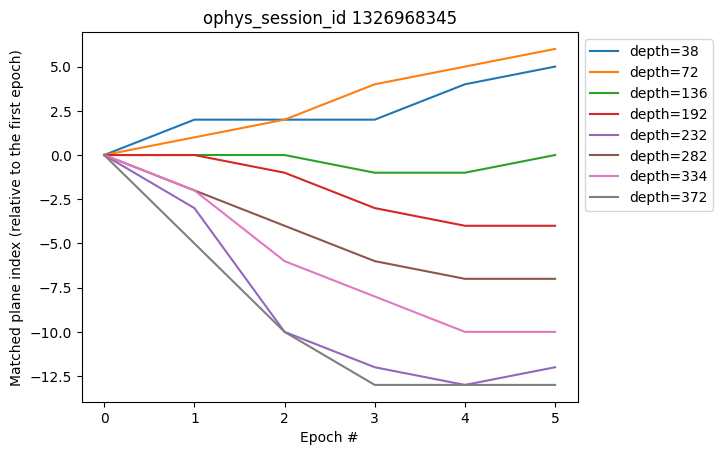

In [9]:
depth = []
for oeid in oeids:
    depth.append(lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0])
depth_order = np.argsort(depth)
fig, ax = plt.subplots()
for doi in depth_order:
    ax.plot([mpi-matched_plane_indices[doi][0] for mpi in matched_plane_indices[doi]], label=f'depth={depth[doi]}')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Epoch #')
ax.set_ylabel('Matched plane index (relative to the first epoch)')
ax.set_title(f'ophys_session_id {osid}')

### 4x2 and 2x4

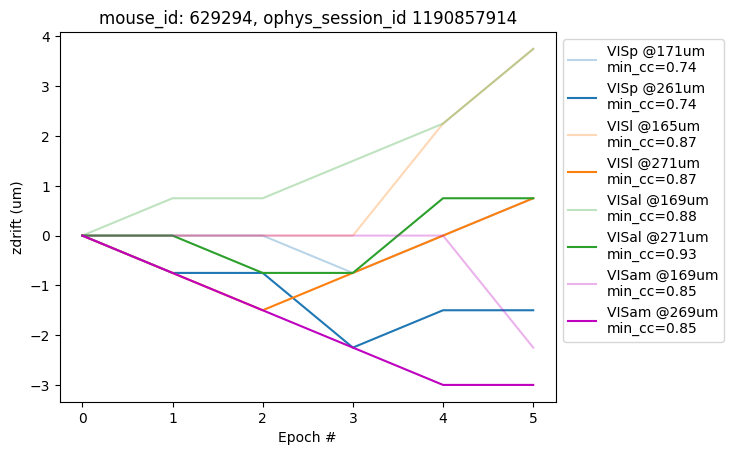

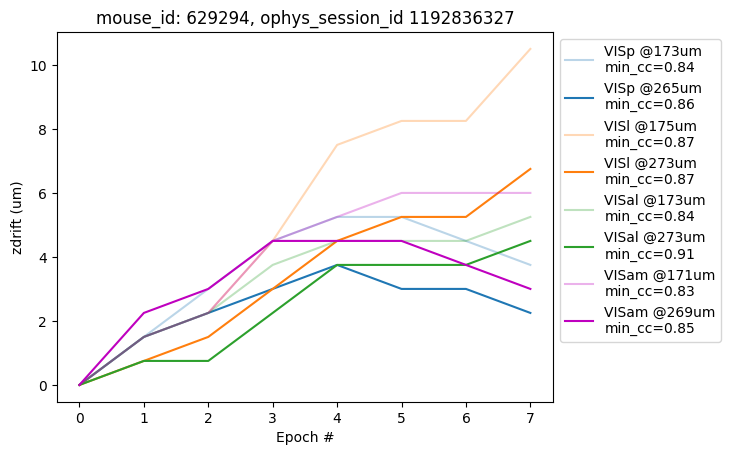

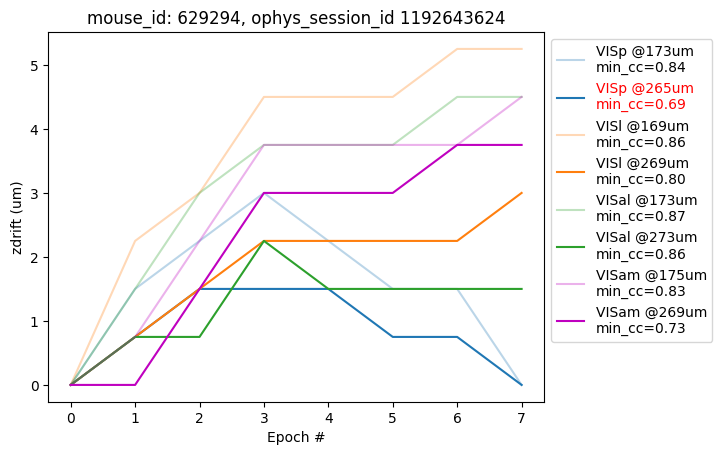

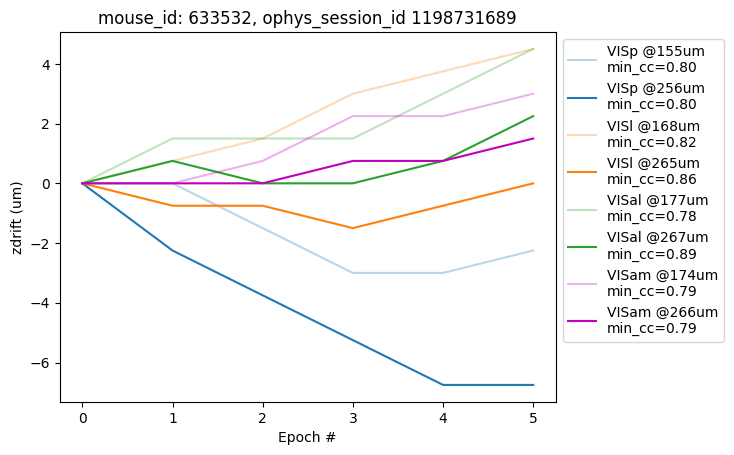

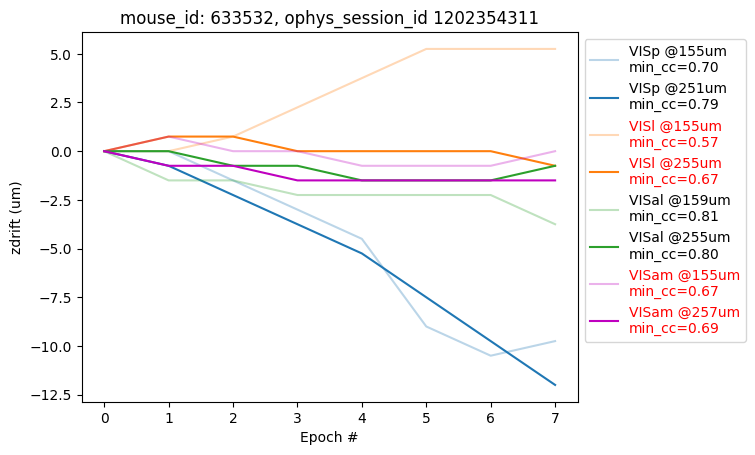

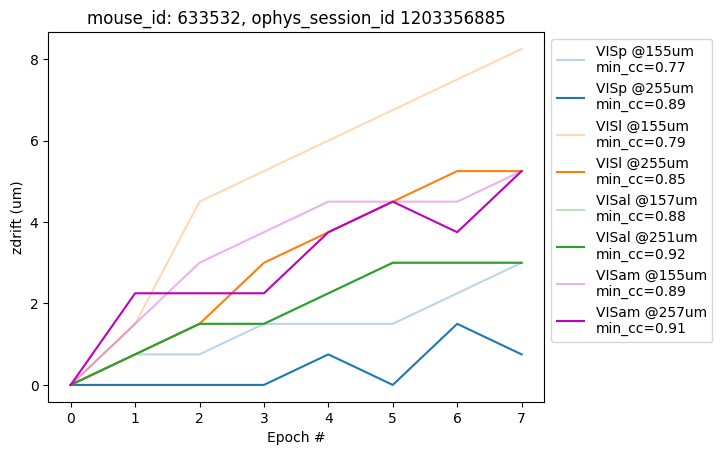

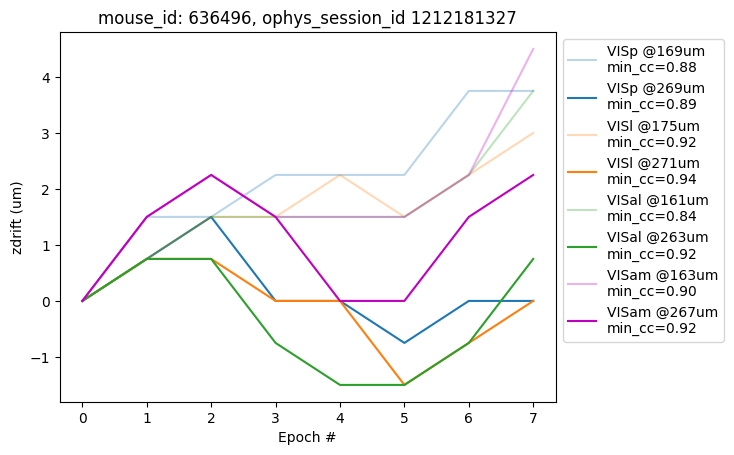

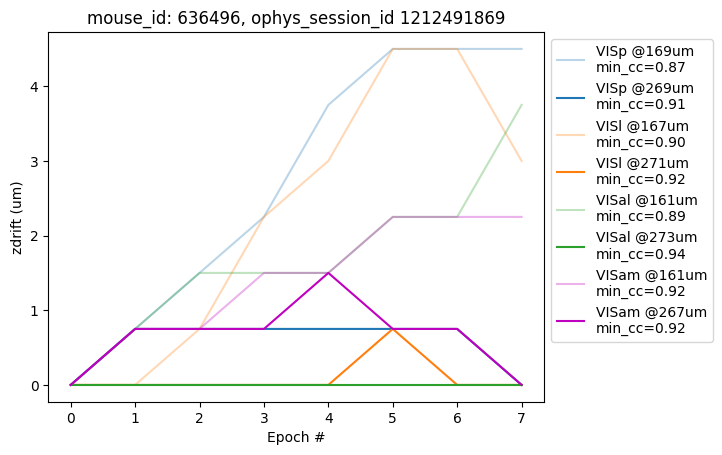

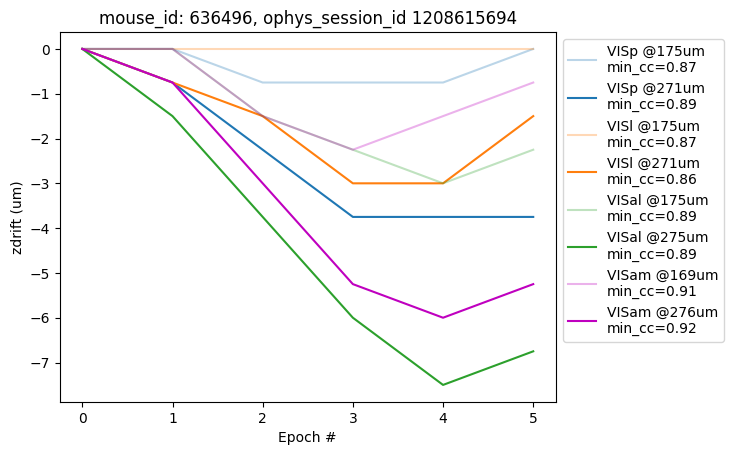

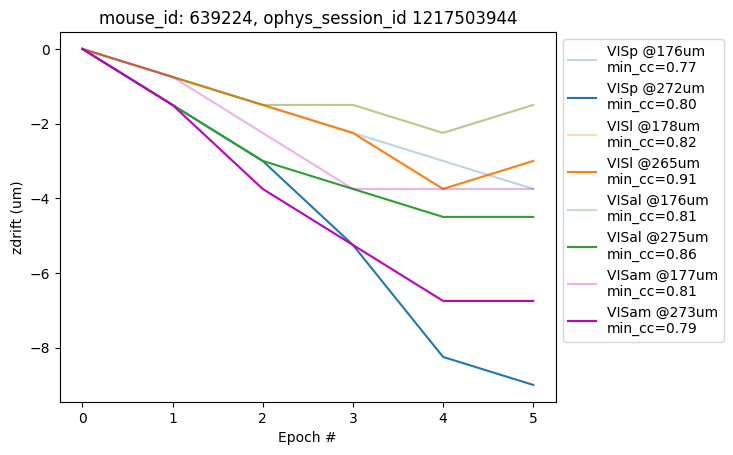

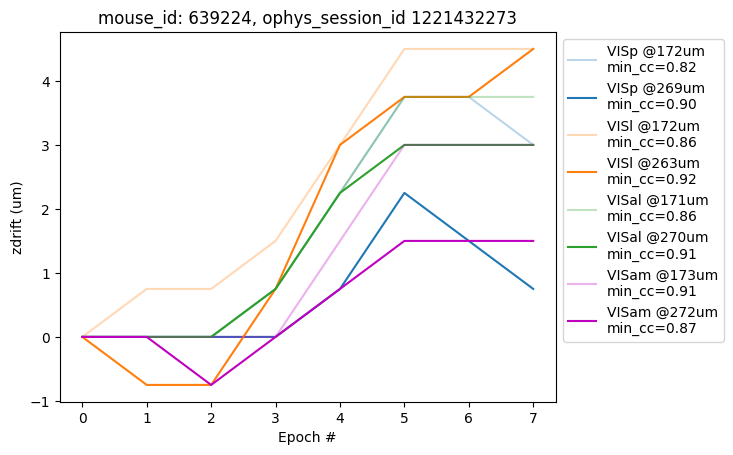

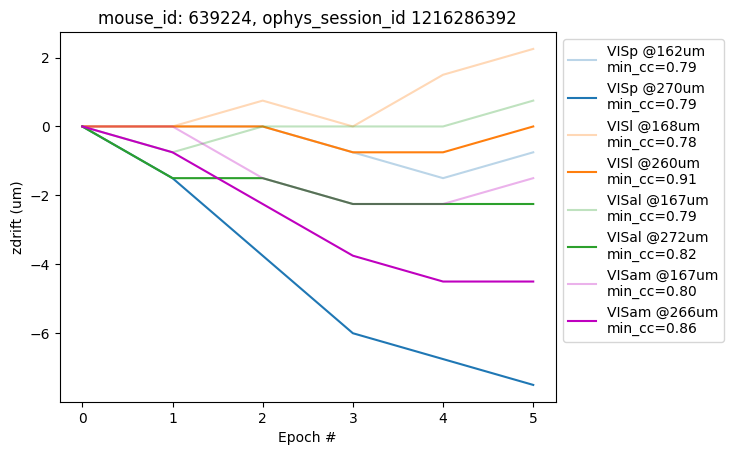

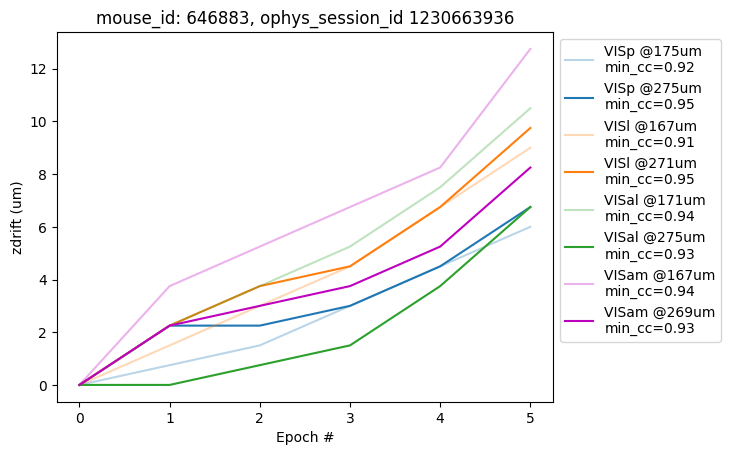

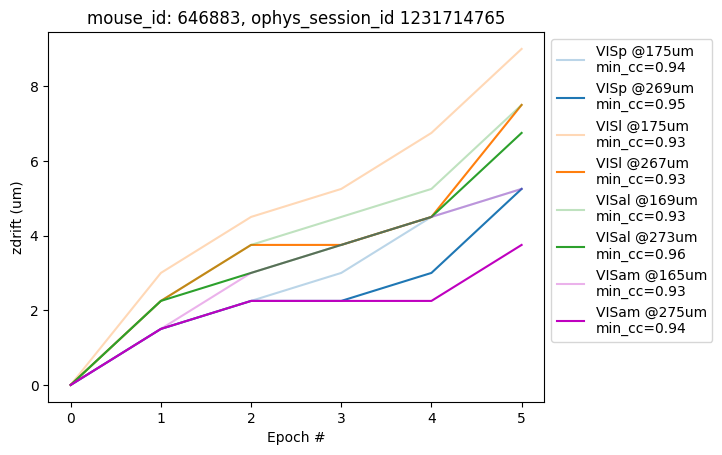

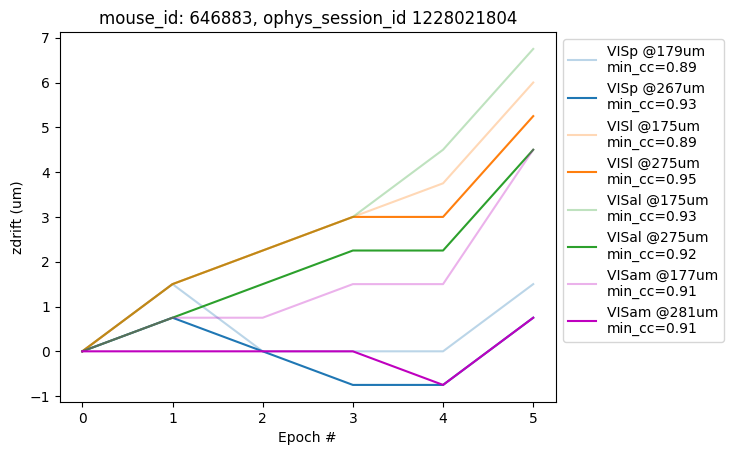

In [154]:
temp_table = multiplane_zdrift_osids.query('config == "4x2"')
osids = temp_table.ophys_session_id.unique()
for osid in osids:
    mid = temp_table.query('ophys_session_id == @osid').mouse_id.values[0]
    # get zdrift results
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
    min_corrcoef = [np.min(cc) for cc in corrcoef]

    # get depth and region
    depth = []
    region = []
    for oeid in oeids:
        try:
            current_depth = lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
            current_region = lamf_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0]
        except:
            current_depth, current_region = get_depth_region_from_db(oeid)
        depth.append(current_depth)
        region.append(current_region)
    
    # order the table by region and depth
    region_order = ['VISp', 'VISl', 'VISal', 'VISam']
    temp_order_table = pd.DataFrame({'depth': depth, 'region': region, 'oeid': oeids,
                                    'matched_plane_indices': matched_plane_indices,
                                    'min_corrcoef': min_corrcoef})
    temp_order_table['region_order'] = temp_order_table.region.apply(lambda x: region_order.index(x))
    temp_order_table = temp_order_table.sort_values(by=['region_order', 'depth']).reset_index(drop=True)

    # plot
    colors = ['C0', 'C0', 'C1', 'C1', 'C2', 'C2', 'm', 'm']
    fig, ax = plt.subplots()
    for i, row in temp_order_table.iterrows():
        zdrift = np.array([mpi-row.matched_plane_indices[0] for mpi in row.matched_plane_indices]) * 0.75
        ax.plot(zdrift, color=colors[i], alpha=1-((i+1)%2)*0.7,
                label=f'{row.region} @{row.depth}um\nmin_cc={row.min_corrcoef:.2f}')
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if min_corrcoef < 0.7, set the text color to red
    min_corrcoef_ordered = temp_order_table.min_corrcoef.values
    for i, text in enumerate(legend.get_texts()):
        if min_corrcoef_ordered[i] < 0.7:
            text.set_color('red')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('zdrift (um)')
    ax.set_title(f'mouse_id: {mid}, ophys_session_id {osid}')



C:\Users\jinho.kim\Github\visual_behavior_analysis\visual_behavior\database.py:729: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\jinho.kim\Github\visual_behavior_analysis\visual_behavior\database.py:729: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\jinho.kim\Github\visual_behavior_analysis\visual_behavior\database.py:729: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\jinho.kim\Github\visual_behavior_analysi

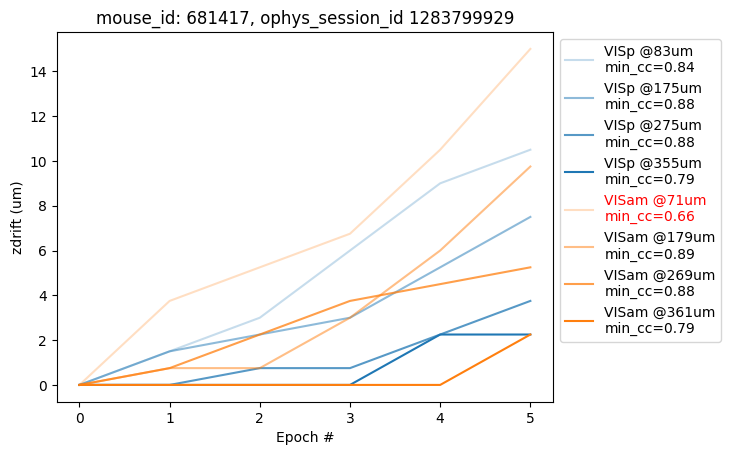

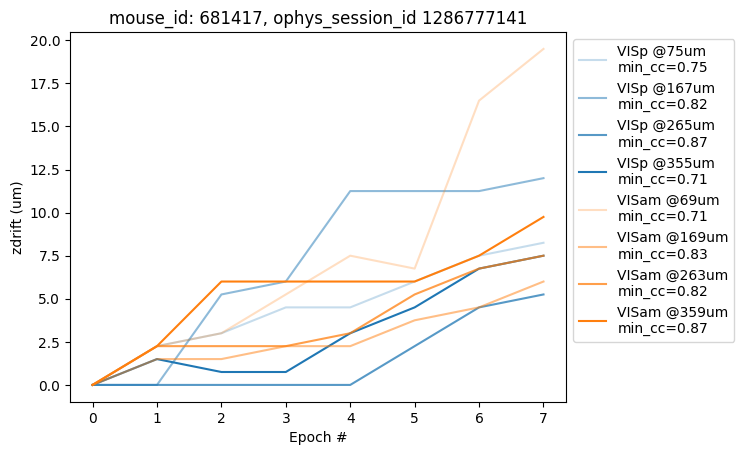

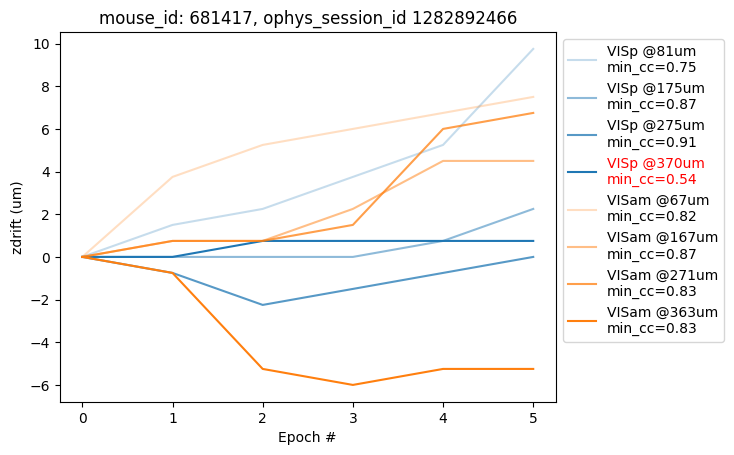

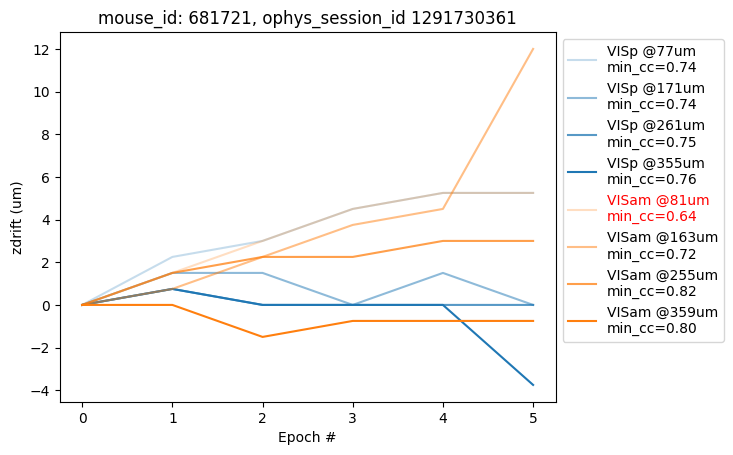

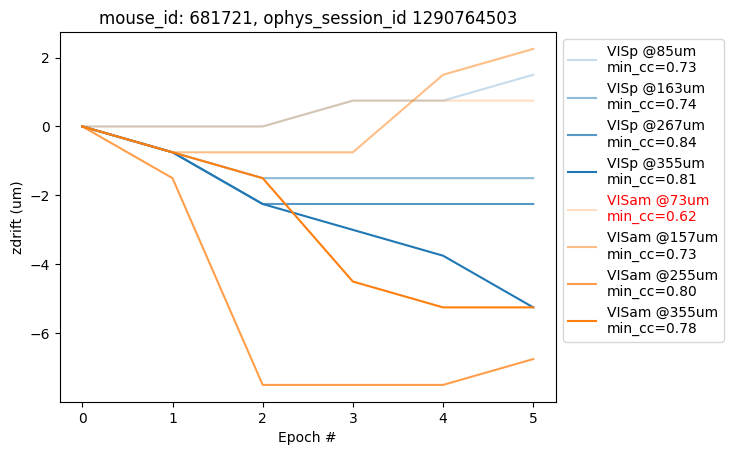

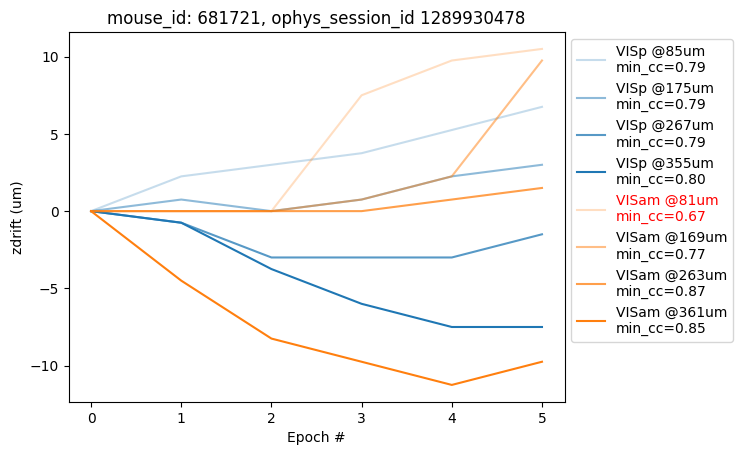

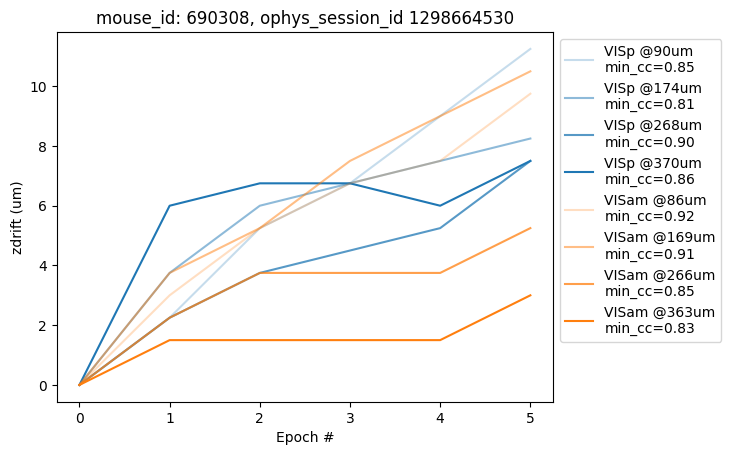

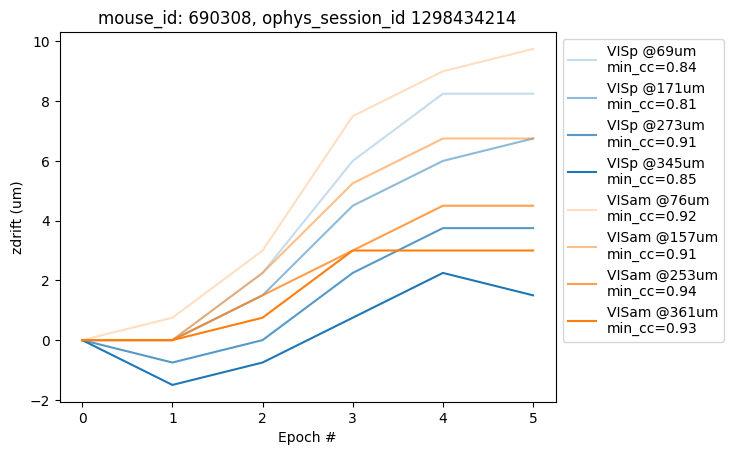

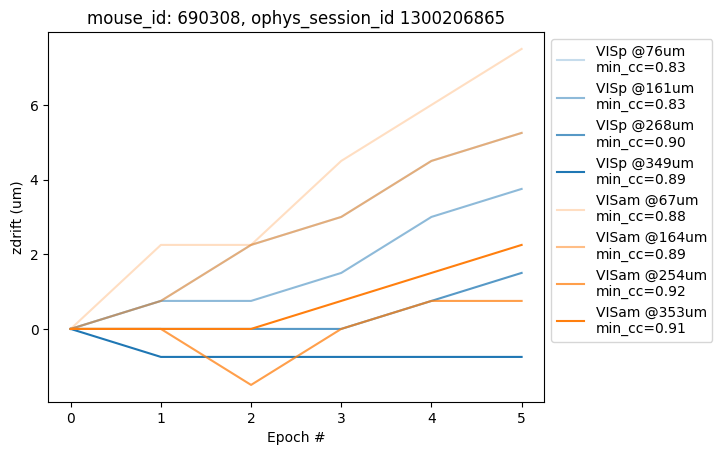

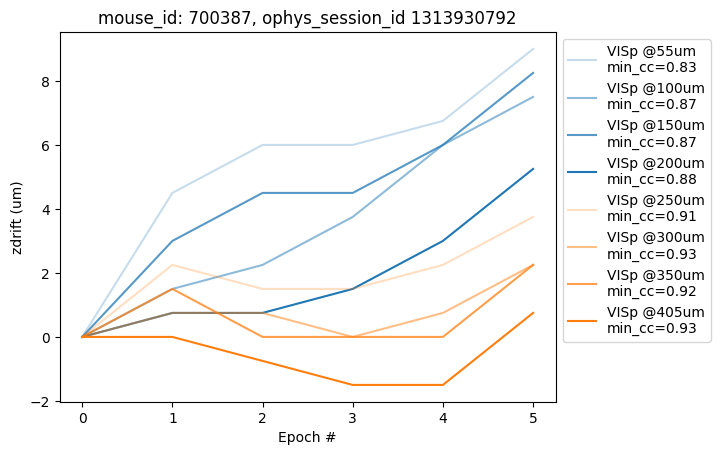

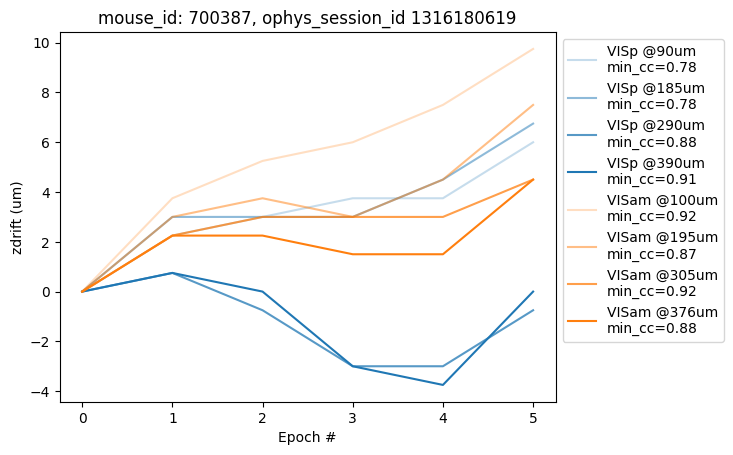

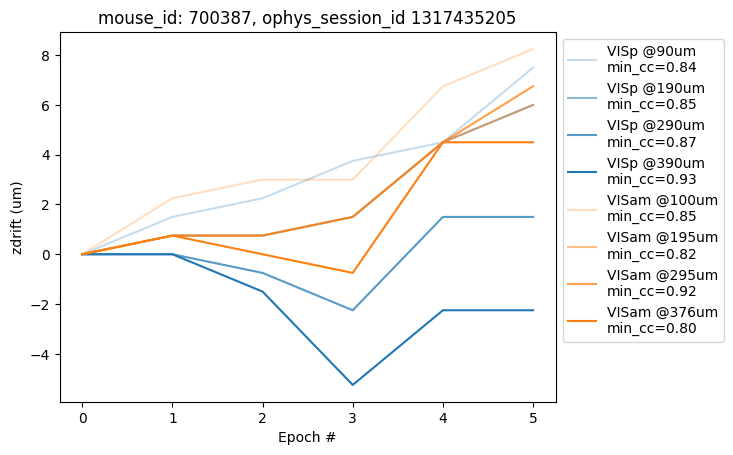

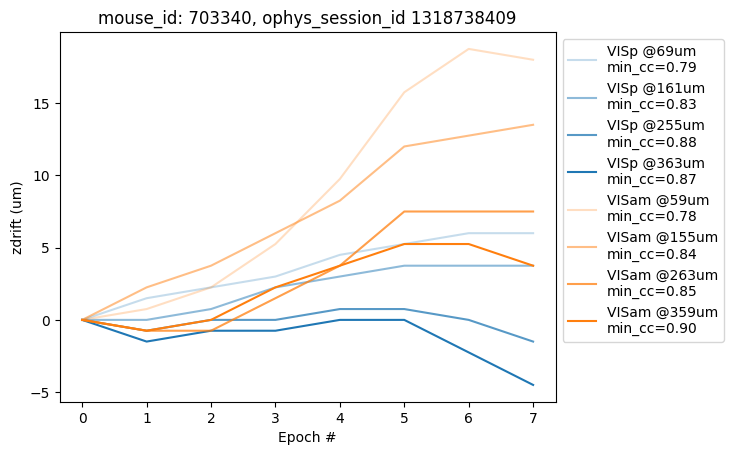

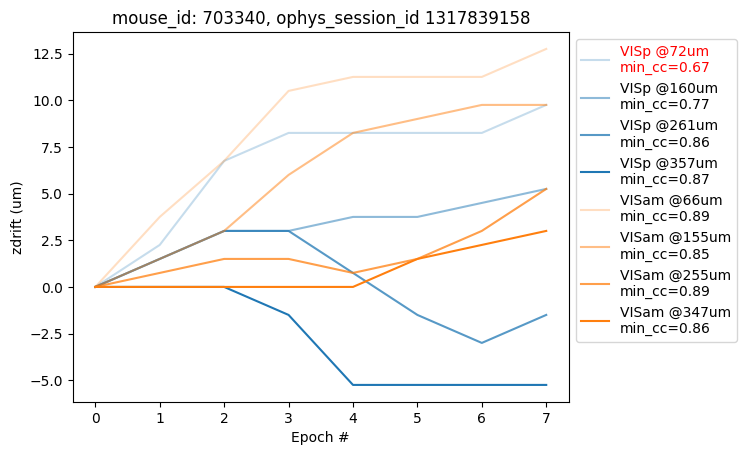

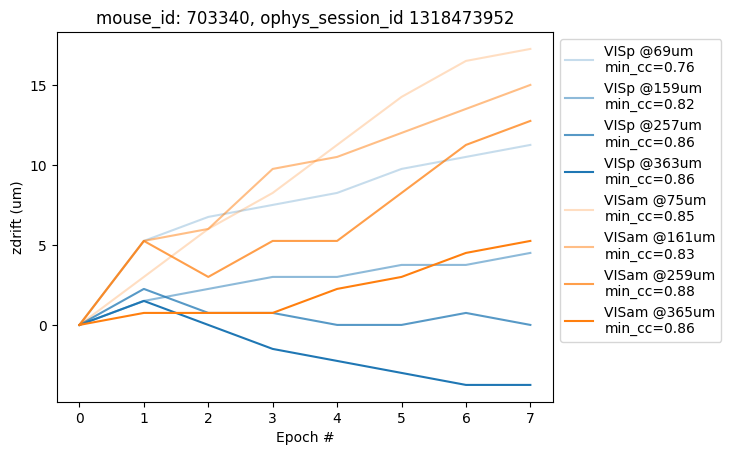

In [53]:
temp_table = multiplane_zdrift_osids.query('config == "2x4"')
osids = temp_table.ophys_session_id.unique()
for osid in osids:
    mid = temp_table.query('ophys_session_id == @osid').mouse_id.values[0]
    # get zdrift results
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
    min_corrcoef = [np.min(cc) for cc in corrcoef]

    # get depth and region
    depth = []
    region = []
    for oeid in oeids:
        try:
            current_depth = lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
            current_region = lamf_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0]
        except:
            current_depth, current_region = get_depth_region_from_db(oeid)
        depth.append(current_depth)
        region.append(current_region)
    
    # order the table by region and depth
    region_order = ['VISp', 'VISam']
    temp_order_table = pd.DataFrame({'depth': depth, 'region': region, 'oeid': oeids,
                                    'matched_plane_indices': matched_plane_indices,
                                    'min_corrcoef': min_corrcoef})
    temp_order_table['region_order'] = temp_order_table.region.apply(lambda x: region_order.index(x))
    temp_order_table = temp_order_table.sort_values(by=['region_order', 'depth']).reset_index(drop=True)

    # plot
    colors = ['C0', 'C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C1']
    fig, ax = plt.subplots()
    for i, row in temp_order_table.iterrows():
        zdrift = np.array([mpi-row.matched_plane_indices[0] for mpi in row.matched_plane_indices]) * 0.75
        ax.plot(zdrift, color=colors[i], alpha=(i%4)*0.25+0.25,
                label=f'{row.region} @{row.depth}um\nmin_cc={row.min_corrcoef:.2f}')
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if min_corrcoef < 0.7, set the text color to red
    min_corrcoef_ordered = temp_order_table.min_corrcoef.values
    for i, text in enumerate(legend.get_texts()):
        if min_corrcoef_ordered[i] < 0.7:
            text.set_color('red')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('zdrift (um)')
    ax.set_title(f'mouse_id: {mid}, ophys_session_id {osid}')


In [50]:
for i, row in temp_order_table.iterrows():
    print((i%4)*0.25+0.25)


0.25
0.5
0.75
1.0
0.25
0.5
0.75
1.0


In [31]:
temp_order_table

depth region        oeid     matched_plane_indices  min_corrcoef  \
0     83   VISp  1283950652  [25, 27, 29, 33, 37, 39]      0.844667   
1    175   VISp  1283950649  [27, 29, 30, 31, 34, 37]      0.878051   
2    275   VISp  1283950651  [31, 31, 32, 32, 34, 36]      0.875906   
3    355   VISp  1283950654  [30, 30, 30, 30, 33, 33]      0.794383   
4     71  VISam  1283950658  [22, 27, 29, 31, 36, 42]      0.662107   
5    179  VISam  1283950655  [26, 27, 27, 30, 34, 39]      0.890020   
6    269  VISam  1283950657  [33, 34, 36, 38, 39, 40]      0.879859   
7    361  VISam  1283950660  [34, 34, 34, 34, 34, 37]      0.790763   

   region_order  
0             0  
1             0  
2             0  
3             0  
4             1  
5             1  
6             1  
7             1

In [21]:
osid = osids[0]
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
oeid = oeids[0]
lamf_table.query('ophys_experiment_id == @oeid')

equipment_name    donor_id  \
ophys_experiment_id                              
1283950655                  MESO.2  1274324881   

                                                         full_genotype  \
ophys_experiment_id                                                      
1283950655           Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   

                    mouse_id                        reporter_line  \
ophys_experiment_id                                                 
1283950655            681417  Ai195(TIT2L-GC7s-ICF-IRES-tTA2)-hyg   

                                           driver_line sex  age_in_days  \
ophys_experiment_id                                                       
1283950655           [Slc32a1-T2A-FlpO, Gad2-IRES-Cre]   M         82.0   

                                              foraging_id       cre_line  ...  \
ophys_experiment_id                                                       ...   
1283950655           bfb6d142-e317-414c-aebb-214e8f82d525  Gad2-IRES-Cre  ...   

                                  session_name  isi_experiment_id  \
ophys_experiment_id                                                 
1283950655           20230718_681417_training3         1277589639   

                     imaging_depth  targeted_structure  published_at  \
ophys_experiment_id                                                    
1283950655                     179               VISam           NaT   

                        date_of_acquisition                     session_type  \
ophys_experiment_id                                                            
1283950655          2023-07-18 16:55:21.391  TRAINING_3_images_A_10uL_reward   

                     experience_level passive image_set  
ophys_experiment_id                                      
1283950655                       None   False         e  

[1 rows x 31 columns]

## Getting results from HPC run
- qc/2p_data/z_drift/scripts/multi_plane_zdrift_sbatch.py

In [10]:
load_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
multiplane_zdrift_osids = pd.read_csv(load_dir / 'multiplane_zdrift_osids_240223.csv')
multiplane_zdrift_osids.head()

mouse_id  ophys_session_id config                     session_type
0    629294        1190857914    4x2  TRAINING_3_images_A_10uL_reward
1    629294        1192836327    4x2                 OPHYS_4_images_B
2    629294        1192643624    4x2                 OPHYS_1_images_A
3    633532        1198731689    4x2              TRAINING_1_gratings
4    633532        1202354311    4x2                 OPHYS_4_images_B

In [11]:
len(multiplane_zdrift_osids)

39

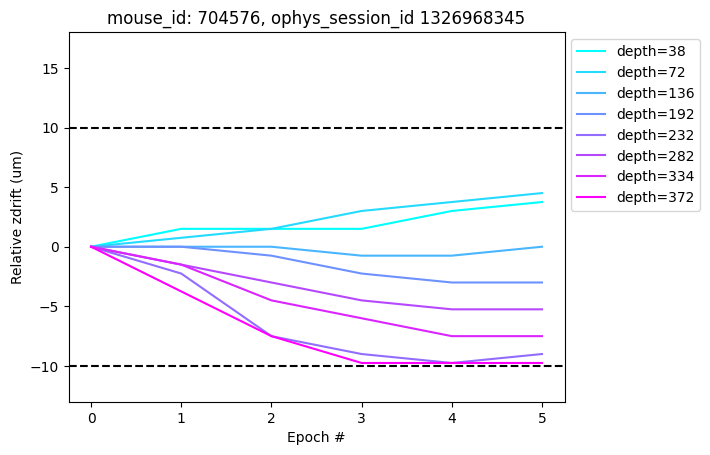

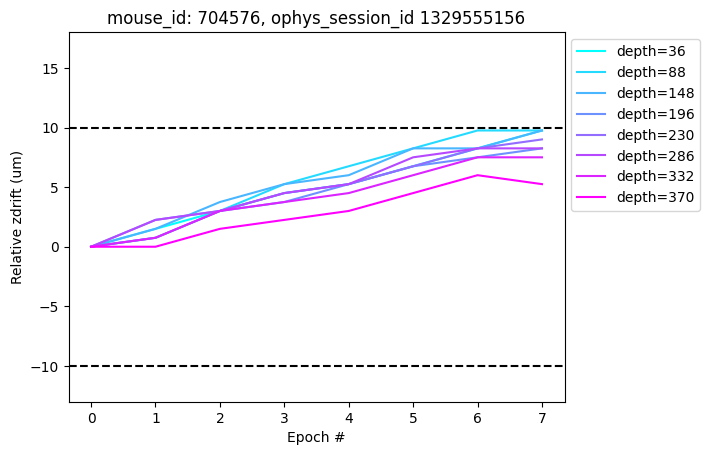

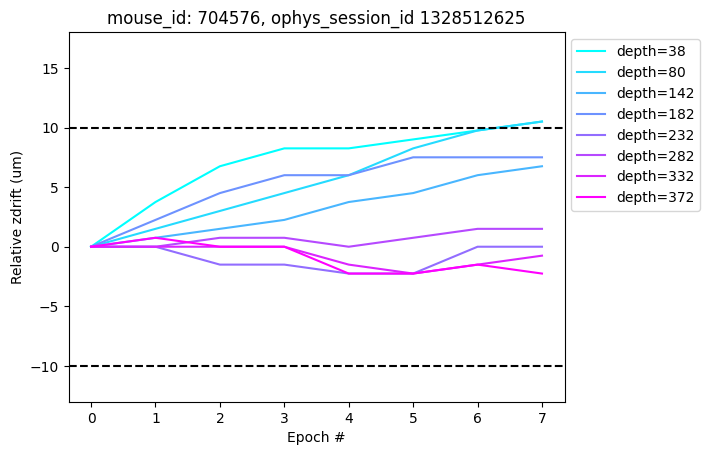

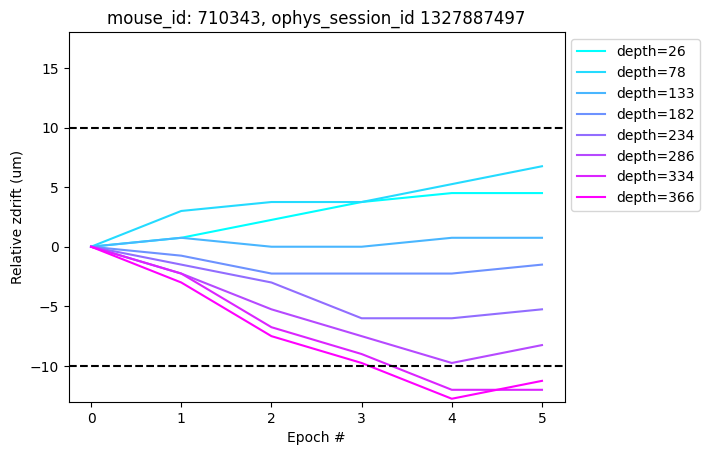

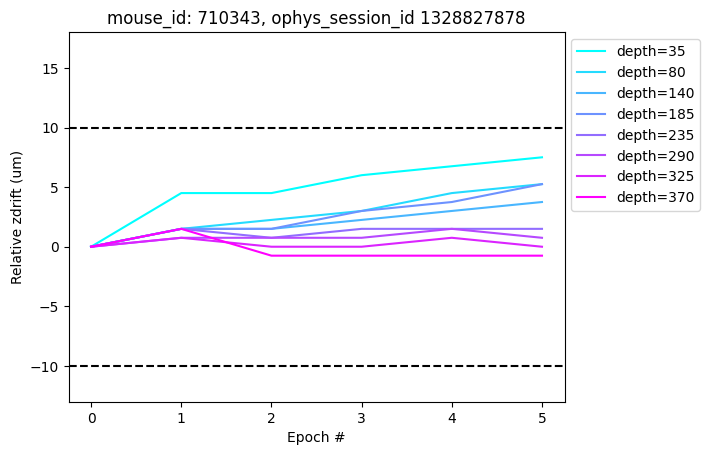

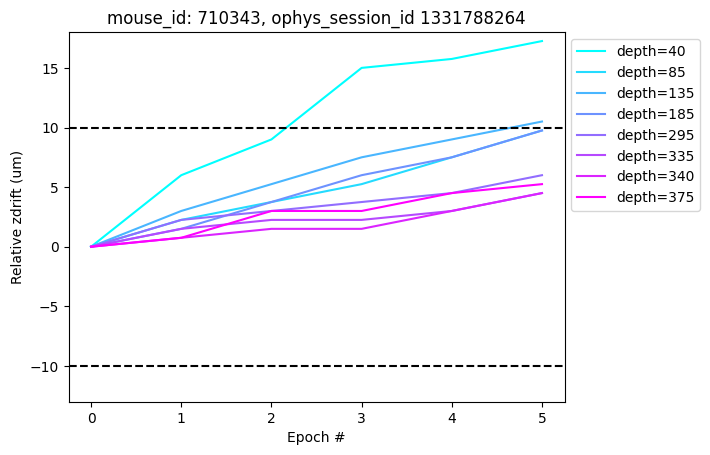

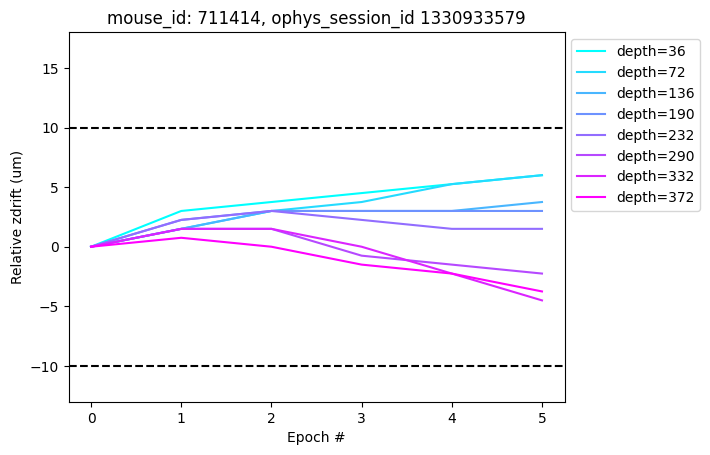

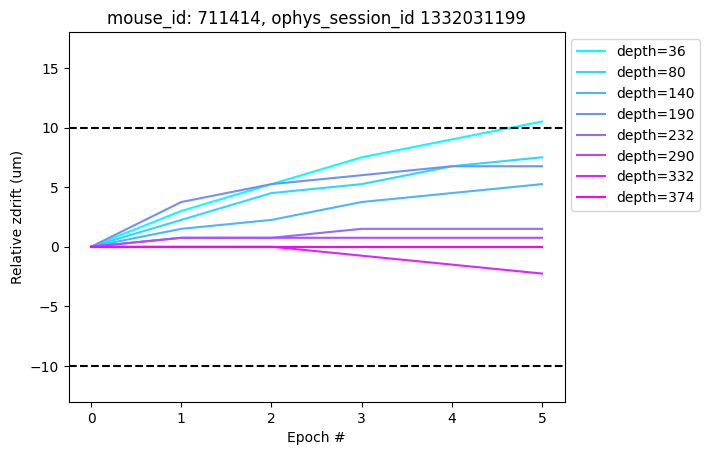

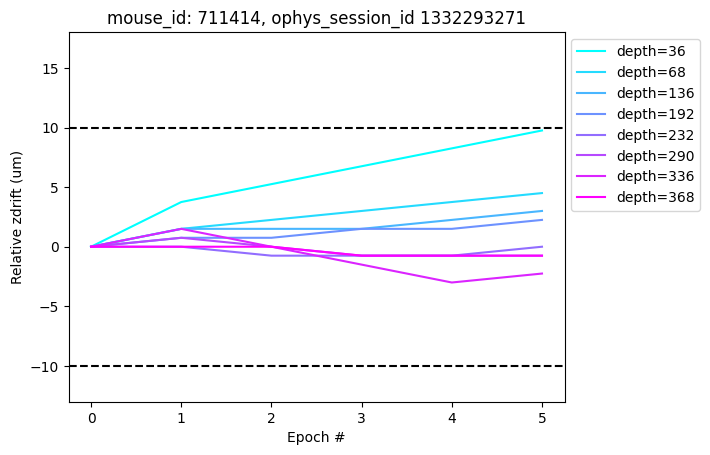

In [23]:
temp_table = multiplane_zdrift_osids.query('config == "1x8"')
osids = temp_table.ophys_session_id.unique()
local_zstack_interval = 0.75
import matplotlib as mpl
colors = mpl.cm.get_cmap('cool')
for osid in osids:
    mid = temp_table.query('ophys_session_id == @osid').mouse_id.values[0]
    # get zdrift results
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
    min_corrcoef = [np.min(cc) for cc in corrcoef]
    # get depth
    depth = []
    for oeid in oeids:
        try:
            current_depth = lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
        except:
            current_depth, current_region = get_depth_region_from_db(oeid)
        depth.append(current_depth)
    depth_order = np.argsort(depth)
    fig, ax = plt.subplots()
    for ii, doi in enumerate(depth_order):
        zdrift = np.array([mpi-matched_plane_indices[doi][0] for mpi in matched_plane_indices[doi]]) * local_zstack_interval
        # ax.plot(zdrift, label=f'depth={depth[doi]}\nmin_cc={min_corrcoef[doi]:.2f}',
        #         color=colors(ii/(len(depth_order)-1)))
        ax.plot(zdrift, label=f'depth={depth[doi]}',
                color=colors(ii/(len(depth_order)-1)))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if min_corrcoef < 0.7, set the text color to red
    # min_corrcoef_ordered = temp_order_table.min_corrcoef.values
    # for doi, text in enumerate(legend.get_texts()):
    #     if min_corrcoef[doi] < 0.7:
    #         text.set_color('red')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Relative zdrift (um)')
    ax.set_title(f'mouse_id: {mid}, ophys_session_id {osid}')

    ax.set_ylim(-13, 18)

    ax.axhline(10, color='k', linestyle='--')
    ax.axhline(-10, color='k', linestyle='--')

In [70]:
# checking the session type (is any of them passive?)
osid = 1328512625
session_type = lamf_table.query('ophys_session_id == @osid').session_type.unique()
print(session_type)

['OPHYS_1_images_A']


# Interim summary
- z-drift is variable between depths and regions
    - The variance is also variable across sessions (even within a mouse)
- At least in 1x8 configuration
    - Total water consumption might be related to z-drift variation
    

# Next steps
- First, estimate the efficacy of online motion correction using global mean
- Calculate total water consumption / total run distance VS z-drift variation at the end / top2 vs bottom2 correlation
- Look at temporal dynamics of total water consumption / running distance compared to zdrift variation across epochs
- Focus on 1x8 for now


## Efficacy of online motion correction
- Now let's look at all GAD2-Cre mice from 2x4 and 1x8 configurations
    - Subtract the mean z-drift of all planes from each plane
- Let's also cover z-drift between first and last 500 frames to match with mouse-seeks process
    - To compare with mouse-seeks protocol
    - To cover the full motion

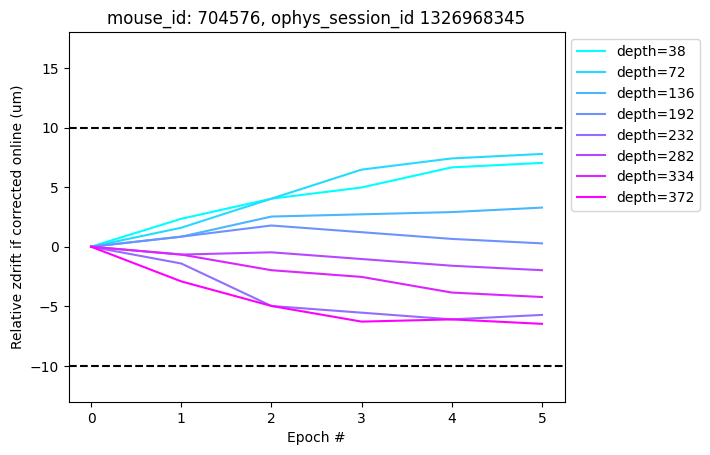

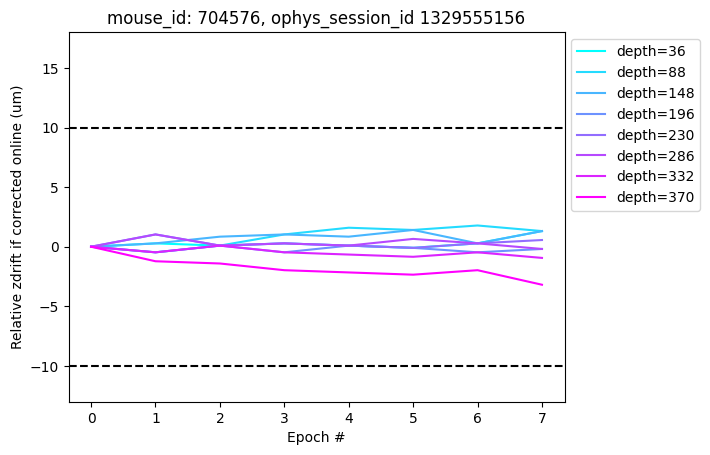

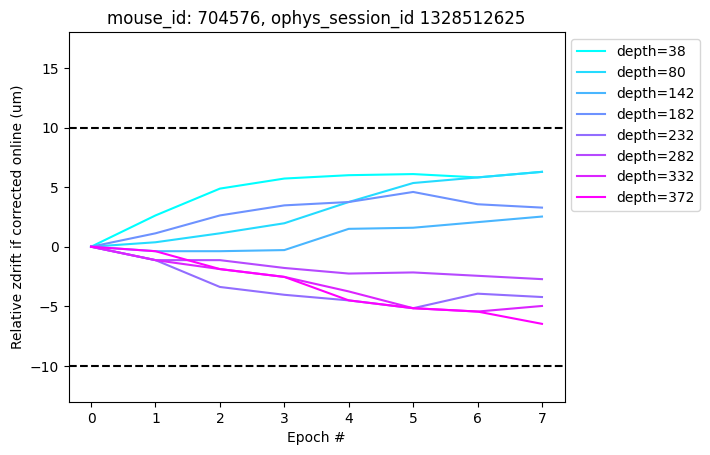

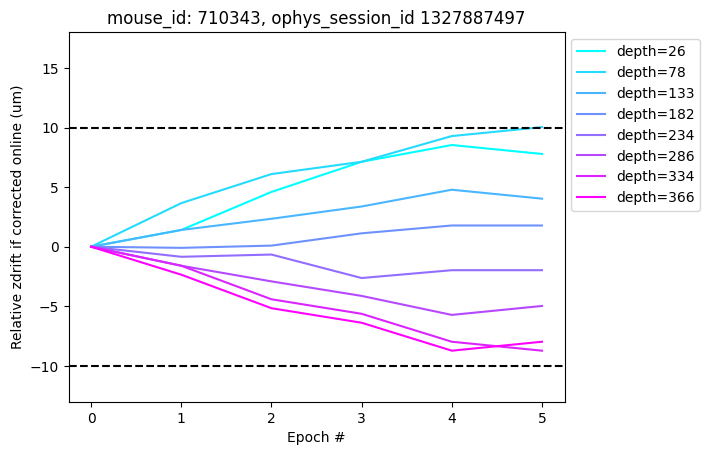

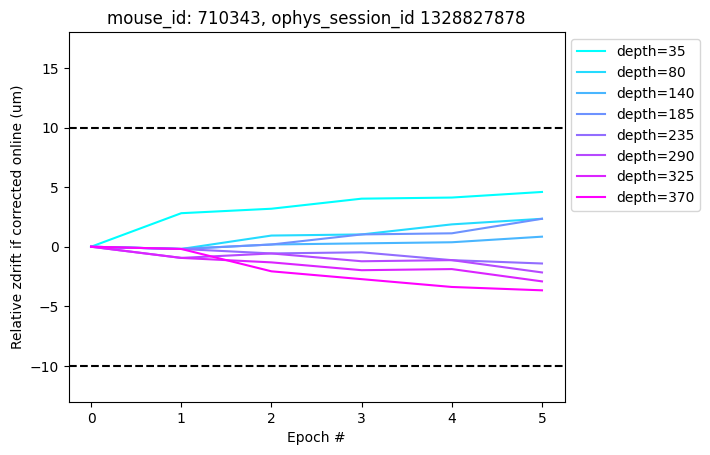

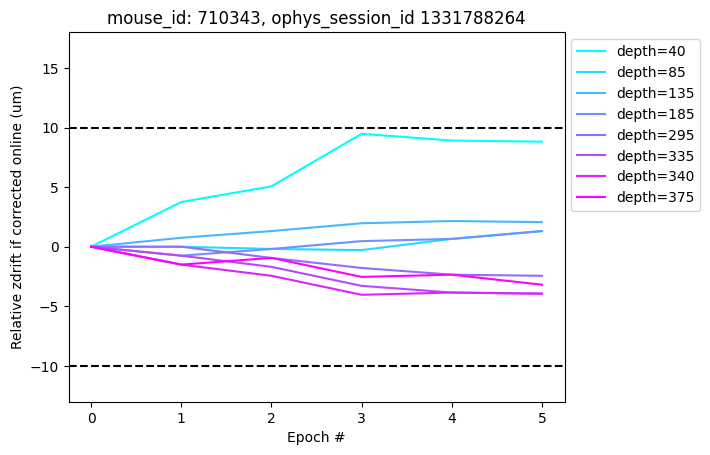

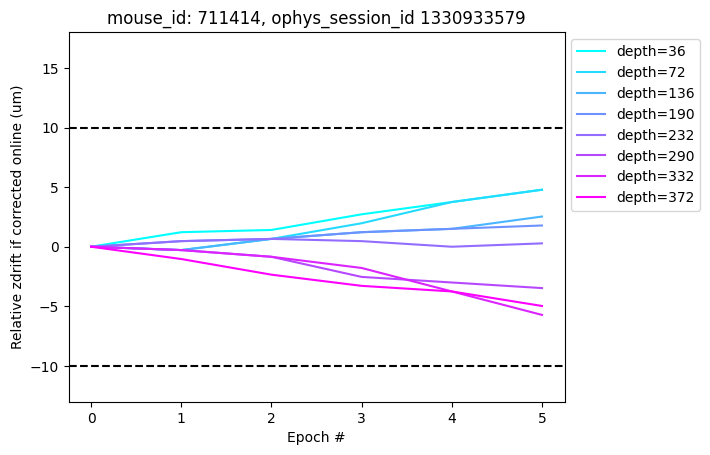

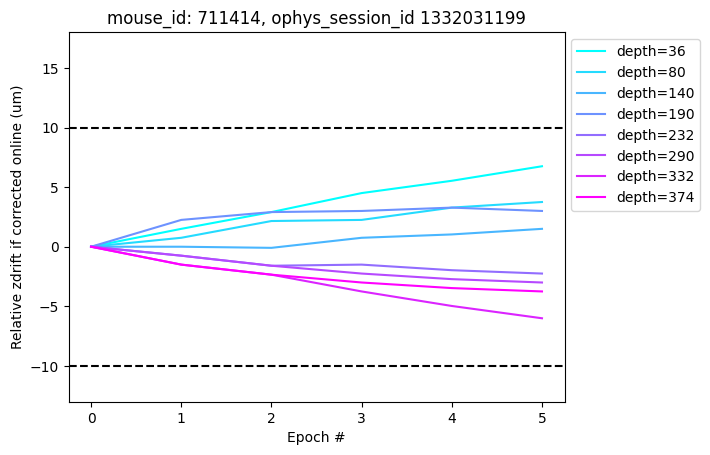

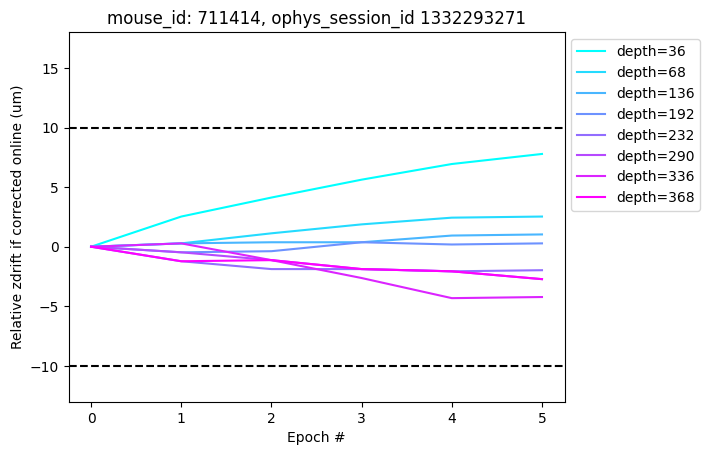

In [22]:
temp_table = multiplane_zdrift_osids.query('config == "1x8"')
osids = temp_table.ophys_session_id.unique()
local_zstack_interval = 0.75
colors = mpl.cm.get_cmap('cool')
for osid in osids:
    mid = temp_table.query('ophys_session_id == @osid').mouse_id.values[0]
    # get zdrift results
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, load_dir)
    min_corrcoef = [np.min(cc) for cc in corrcoef]
    # get depth
    depth = []
    for oeid in oeids:
        try:
            current_depth = lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
        except:
            current_depth, current_region = get_depth_region_from_db(oeid)
        depth.append(current_depth)
    depth_order = np.argsort(depth)
    fig, ax = plt.subplots()
    relative_zdrift = []
    for doi in depth_order:
        zdrift = np.array([mpi-matched_plane_indices[doi][0] for mpi in matched_plane_indices[doi]]) * local_zstack_interval
        relative_zdrift.append(zdrift)
    relative_zdrift = np.array(relative_zdrift)
    estimated_corrected_zdrift = relative_zdrift - relative_zdrift.mean(axis=0)    
    for i, doi in enumerate(depth_order):
        ax.plot(estimated_corrected_zdrift[i,:], label=f'depth={depth[doi]}',
                color=colors(i/(len(depth_order)-1)))
        # ax.plot(estimated_corrected_zdrift[i,:], label=f'depth={depth[doi]}\nmin_cc={min_corrcoef[doi]:.2f}')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if min_corrcoef < 0.7, set the text color to red
    # min_corrcoef_ordered = temp_order_table.min_corrcoef.values
    # for doi, text in enumerate(legend.get_texts()):
    #     if min_corrcoef[doi] < 0.7:
    #         text.set_color('red')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Relative zdrift if corrected online (um)')
    ax.set_title(f'mouse_id: {mid}, ophys_session_id {osid}')

    ax.set_ylim(-13, 18)
    ax.axhline(10, color='k', linestyle='--')
    ax.axhline(-10, color='k', linestyle='--')

### Add first and last 500 frames z-drift

In [88]:
from importlib import reload
reload(dem)

<module 'brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module' from 'c:\\users\\jinho.kim\\github\\brain_observatory_qc\\brain_observatory_qc\\pipeline_dev\\scripts\\depth_estimation_module.py'>

In [89]:
_ = dem.get_experiment_zdrift_first_last(oeid, oeid, save_dir=save_dir)

### Run this in HPC
- multi_plane_zdrift_sbatch.py, calling multi_plane_zdrift.py

In [9]:
load_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
multiplane_zdrift_osids = pd.read_csv(load_dir / 'multiplane_zdrift_osids_240223.csv')
multiplane_zdrift_osids.head()

mouse_id  ophys_session_id config                     session_type
0    629294        1190857914    4x2  TRAINING_3_images_A_10uL_reward
1    629294        1192836327    4x2                 OPHYS_4_images_B
2    629294        1192643624    4x2                 OPHYS_1_images_A
3    633532        1198731689    4x2              TRAINING_1_gratings
4    633532        1202354311    4x2                 OPHYS_4_images_B

In [3]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)
lamf_table = table.query('project_code == "LearningmFISHTask1A"')
lamf_table = lamf_table[~(lamf_table.session_type.str.contains("TRAINING_0_"))]


In [4]:
last_run_time = datetime(2024, 2, 28, 0, 0, 0)

In [5]:
zdrift_run_table =  lamf_table[lamf_table.apply(lambda x: pd.to_datetime(x.date_of_acquisition) < last_run_time, axis=1)]

In [6]:
zdrift_test_table = zdrift_run_table.groupby('ophys_session_id').apply(lambda x: len(x.targeted_structure.unique())<=2)
osids = zdrift_test_table[zdrift_test_table].index.values
len(osids)


172

In [7]:
np.sort(zdrift_run_table.date_of_acquisition.unique())[-1]

numpy.datetime64('2024-02-27T18:23:35.948000000')

# Online motion correction efficacy
- From the first and last 500 frames as in mouse-seeks

In [42]:
osid = 1243753586
corrcoef, matched_plane_indices, oeids = get_zdrift_results_first_last(osid, load_dir)

In [44]:
local_zstack_interval = 0.75
zdrift = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
corrected_zdrift = zdrift - zdrift.mean()

Text(0, 0.5, 'abs(corrected zdrift) (um)')

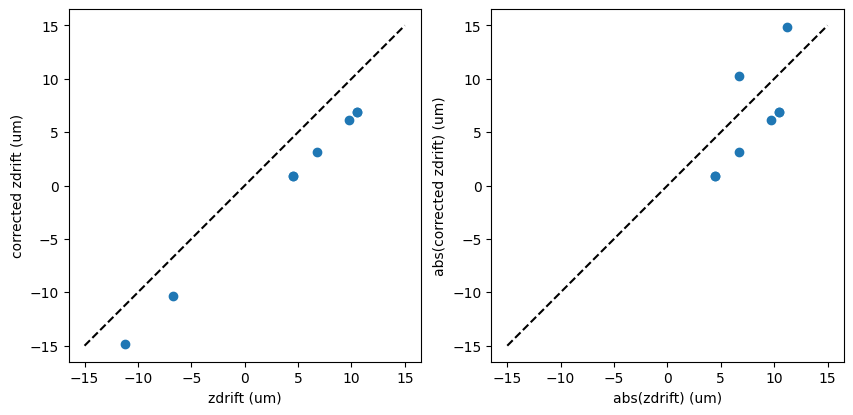

In [49]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter((zdrift), (corrected_zdrift))
ax[0].plot([-15, 15], [-15, 15], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('zdrift (um)')
ax[0].set_ylabel('corrected zdrift (um)')
ax[1].scatter(abs(zdrift), abs(corrected_zdrift))
ax[1].plot([-15, 15], [-15, 15], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('abs(zdrift) (um)')
ax[1].set_ylabel('abs(corrected zdrift) (um)')

### 1x8 configuration

In [10]:
zdrift_test_table = zdrift_run_table.groupby('ophys_session_id').apply(lambda x: len(x.targeted_structure.unique())==1)
osids = zdrift_test_table[zdrift_test_table].index.values
local_zstack_interval = 0.75
zdrift = []
corrected_zdrift = []
osid_list = []
for osid in osids:
    try:
        _, matched_plane_indices, _ = get_zdrift_results_first_last(osid, load_dir)
        zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
        corrected_zdrift_session = zdrift_session - zdrift_session.mean()
        zdrift.append(zdrift_session)
        corrected_zdrift.append(corrected_zdrift_session)
        osid_list.append(osid)
    except:
        pass
print(len(osid_list))
# takes about 2.3 minutes

46


In [52]:
len(osids)

48

In [56]:
zdrift_all = np.concatenate(zdrift)
corrected_zdrift_all = np.concatenate(corrected_zdrift)


In [58]:
zdrift_all.max()

18.75

In [60]:
corrected_zdrift_all.max()

11.15625

Text(0.5, 1.0, '1X8 configuration')

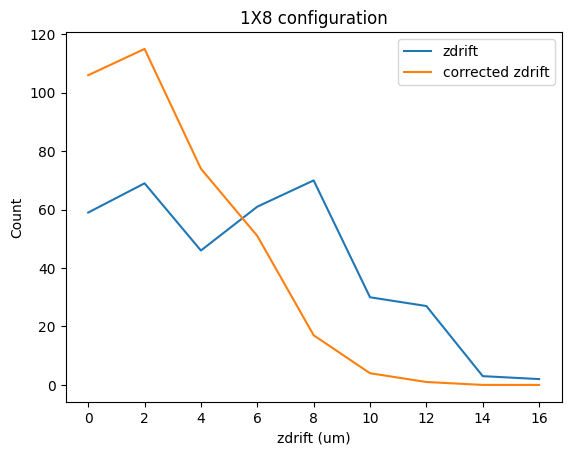

In [66]:
bins = np.arange(0,20,2)
fig, ax = plt.subplots()
ax.plot(bins[:-1], np.histogram(abs(zdrift_all), bins=bins)[0], label='zdrift')
ax.plot(bins[:-1], np.histogram(abs(corrected_zdrift_all), bins=bins)[0], label='corrected zdrift')
ax.legend()
ax.set_xlabel('zdrift (um)')
ax.set_ylabel('Count')
ax.set_title('1X8 configuration')

In [67]:
threshold = 10
prop_fail = np.sum(abs(zdrift_all) > threshold) / len(zdrift_all)
prop_corrected_fail = np.sum(abs(corrected_zdrift_all) > threshold) / len(corrected_zdrift_all)
print(f'proportion of zdrift > {threshold}um: {prop_fail:.2f}')
print(f'proportion of corrected zdrift > {threshold}um: {prop_corrected_fail:.2f}')

proportion of zdrift > 10um: 0.17
proportion of corrected zdrift > 10um: 0.01


In [68]:
threshold_list = range(5,11)
prop_fail_list = []
prop_corrected_fail_list = []
for threshold in threshold_list:
    prop_fail = np.sum(abs(zdrift_all) > threshold) / len(zdrift_all)
    prop_corrected_fail = np.sum(abs(corrected_zdrift_all) > threshold) / len(corrected_zdrift_all)
    prop_fail_list.append(prop_fail)
    prop_corrected_fail_list.append(prop_corrected_fail)
    

Text(0.5, 1.0, '1X8 configuration')

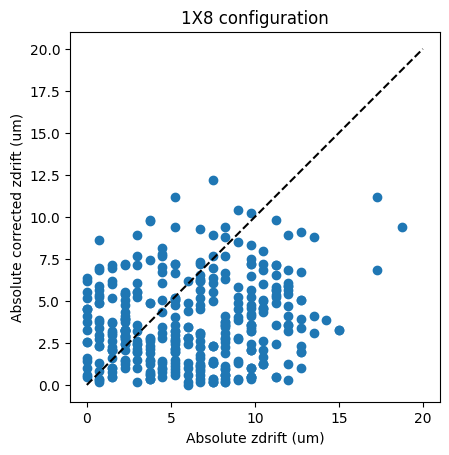

In [77]:
fig, ax = plt.subplots()
ax.scatter(abs(zdrift_all), abs(corrected_zdrift_all))
ax.plot([0, 20], [0, 20], 'k--')
ax.axis('square')
ax.set_xlabel('Absolute zdrift (um)')
ax.set_ylabel('Absolute corrected zdrift (um)')
ax.set_title('1X8 configuration')

Text(0.5, 1.0, '1X8 configuration')

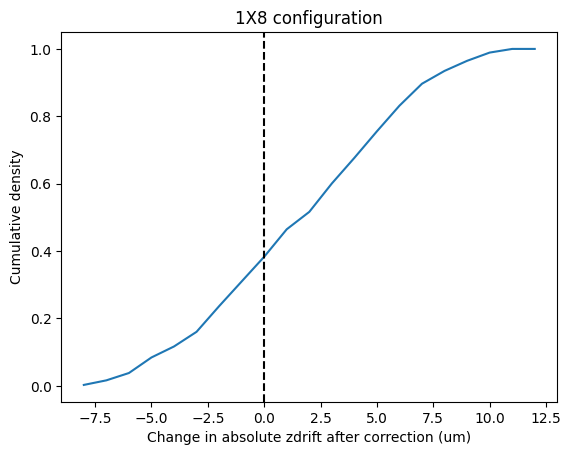

In [84]:
zdrift_change = abs(zdrift_all) - abs(corrected_zdrift_all)
bins = np.arange(-8,14,1)
zdrift_density, _ = np.histogram(zdrift_change, bins=bins)
zdrift_density = zdrift_density / np.sum(zdrift_density)
zdrift_density_cumsum = np.cumsum(zdrift_density)
fig, ax = plt.subplots()
ax.plot(bins[:-1], zdrift_density_cumsum)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel('Change in absolute zdrift after correction (um)')
ax.set_ylabel('Cumulative density')
ax.set_title('1X8 configuration')

Text(0.5, 1.0, '1X8 configuration')

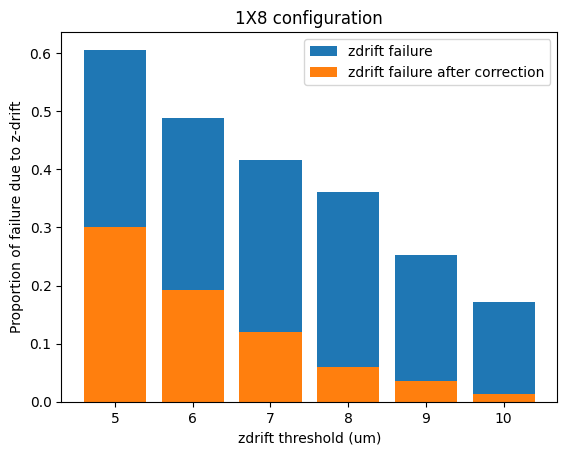

In [72]:
fig, ax = plt.subplots()
ax.bar(threshold_list, prop_fail_list, label='zdrift failure')
ax.bar(threshold_list, prop_corrected_fail_list, label='zdrift failure after correction')
ax.legend()
ax.set_xlabel('zdrift threshold (um)')
ax.set_ylabel('Proportion of failure due to z-drift')
ax.set_title('1X8 configuration')

### 2x4 configuration

In [73]:
zdrift_test_table = zdrift_run_table.groupby('ophys_session_id').apply(lambda x: len(x.targeted_structure.unique())==2)
osids = zdrift_test_table[zdrift_test_table].index.values
local_zstack_interval = 0.75
zdrift = []
corrected_zdrift = []
osid_list = []
for osid in osids:
    try:
        _, matched_plane_indices, _ = get_zdrift_results_first_last(osid, load_dir)
        zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
        corrected_zdrift_session = zdrift_session - zdrift_session.mean()
        zdrift.append(zdrift_session)
        corrected_zdrift.append(corrected_zdrift_session)
        osid_list.append(osid)
    except:
        pass
print(len(osid_list))
print(len(osids))

123
124


In [85]:
zdrift_all = np.concatenate(zdrift)
corrected_zdrift_all = np.concatenate(corrected_zdrift)

Text(0.5, 1.0, '2X4 configuration')

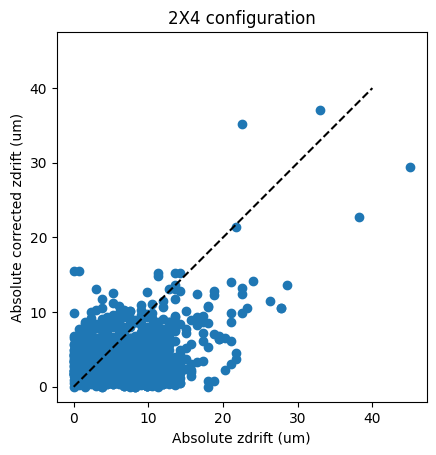

In [87]:
fig, ax = plt.subplots()
ax.scatter(abs(zdrift_all), abs(corrected_zdrift_all))
ax.plot([0, 40], [0, 40], 'k--')
ax.axis('square')
ax.set_xlabel('Absolute zdrift (um)')
ax.set_ylabel('Absolute corrected zdrift (um)')
ax.set_title('2X4 configuration')

(array([  2.,   1.,   0.,   2.,   5.,  20.,  50.,  96.,  87.,  98., 128.,
        154., 125.,  78.,  48.,  46.,  18.,  12.,   5.,   9.]),
 array([-15.5625  , -13.884375, -12.20625 , -10.528125,  -8.85    ,
         -7.171875,  -5.49375 ,  -3.815625,  -2.1375  ,  -0.459375,
          1.21875 ,   2.896875,   4.575   ,   6.253125,   7.93125 ,
          9.609375,  11.2875  ,  12.965625,  14.64375 ,  16.321875,
         18.      ]),
 <BarContainer object of 20 artists>)

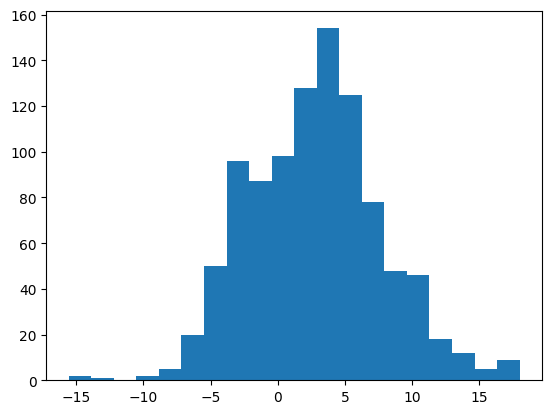

In [88]:
zdrift_change = abs(zdrift_all) - abs(corrected_zdrift_all)
plt.hist(zdrift_change, bins=20)

Text(0.5, 1.0, '2X4 configuration')

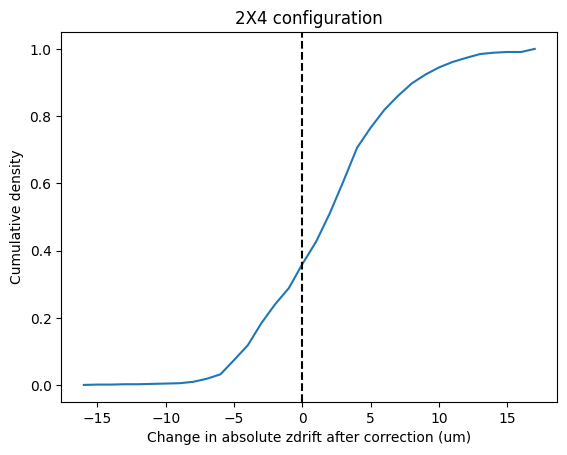

In [89]:
zdrift_change = abs(zdrift_all) - abs(corrected_zdrift_all)
bins = np.arange(-16,19,1)
zdrift_density, _ = np.histogram(zdrift_change, bins=bins)
zdrift_density = zdrift_density / np.sum(zdrift_density)
zdrift_density_cumsum = np.cumsum(zdrift_density)
fig, ax = plt.subplots()
ax.plot(bins[:-1], zdrift_density_cumsum)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel('Change in absolute zdrift after correction (um)')
ax.set_ylabel('Cumulative density')
ax.set_title('2X4 configuration')

Text(0.5, 1.0, '2X4 configuration')

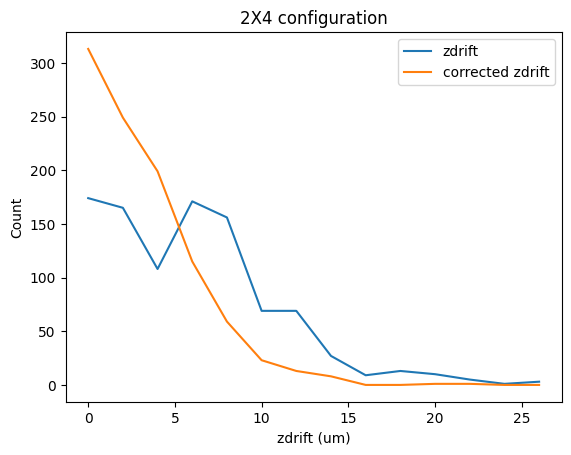

In [91]:
bins = np.arange(0,30,2)
fig, ax = plt.subplots()
ax.plot(bins[:-1], np.histogram(abs(zdrift_all), bins=bins)[0], label='zdrift')
ax.plot(bins[:-1], np.histogram(abs(corrected_zdrift_all), bins=bins)[0], label='corrected zdrift')
ax.legend()
ax.set_xlabel('zdrift (um)')
ax.set_ylabel('Count')
ax.set_title('2X4 configuration')

Text(0.5, 1.0, '2X4 configuration')

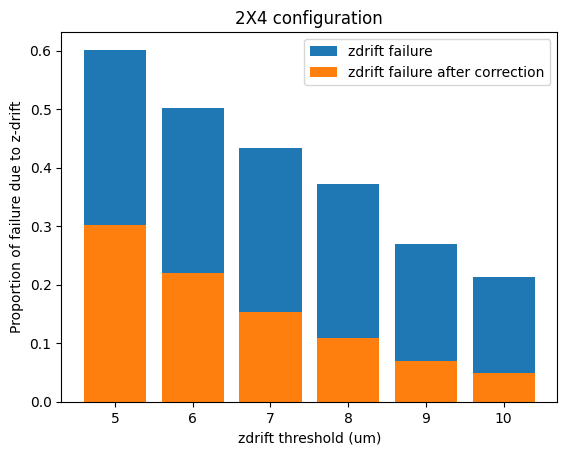

In [93]:
threshold_list = range(5,11)
prop_fail_list = []
prop_corrected_fail_list = []
for threshold in threshold_list:
    prop_fail = np.sum(abs(zdrift_all) > threshold) / len(zdrift_all)
    prop_corrected_fail = np.sum(abs(corrected_zdrift_all) > threshold) / len(corrected_zdrift_all)
    prop_fail_list.append(prop_fail)
    prop_corrected_fail_list.append(prop_corrected_fail)
    
fig, ax = plt.subplots()
ax.bar(threshold_list, prop_fail_list, label='zdrift failure')
ax.bar(threshold_list, prop_corrected_fail_list, label='zdrift failure after correction')
ax.legend()
ax.set_xlabel('zdrift threshold (um)')
ax.set_ylabel('Proportion of failure due to z-drift')
ax.set_title('2X4 configuration')

# Water vs z-drift spread

### 1x8 configuration

In [13]:
# Getting relevant osids
zdrift_test_table = zdrift_run_table.groupby('ophys_session_id').apply(lambda x: len(x.targeted_structure.unique())==1)
osids = zdrift_test_table[zdrift_test_table].index.values


In [12]:
# getting water uptake records (filtering osid based on the record existence)
water_recorded_osid = []
water_volume = []
for osid in osids:
    session = mongo.qc.metrics.find_one({'lims_id': int(osid)})
    if 'change_detection' in session.keys():
        try:
            if 'total_water' in session['change_detection'].keys():
                total_water = session['change_detection']['total_water']
                earned_water = session['change_detection']['earned_water']
            else:
                total_water = session['change_detection']['behavior_stats'][0]['total_water']
                earned_water = session['change_detection']['behavior_stats'][0]['earned_water']
            if 'OPHYS_6_' in lamf_table.query('ophys_session_id == @osid').session_type.unique()[0]:
                water_volume.append(total_water - earned_water)
            else:
                water_volume.append(total_water)
            water_recorded_osid.append(osid)
        except:
            pass
assert len(water_recorded_osid) == len(water_volume)

In [137]:
# getting z-drift spread
# Variance
zdrift_spread = []
num_opids = []
zdrift_osid = []
for osid in water_recorded_osid:
    try:
        _, matched_plane_indices, _ = get_zdrift_results_first_last(osid, load_dir)
        zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
        num_opids.append(len(zdrift_session))
        zdrift_spread.append(zdrift_session.var())
        zdrift_osid.append(osid)
    except:
        pass


In [138]:
water_volume_for_zdrift = []
for osid in zdrift_osid:
    water_volume_for_zdrift.append(water_volume[water_recorded_osid.index(osid)])

In [148]:
zdrift_osid = np.array(zdrift_osid)
water_volume_for_zdrift = np.array(water_volume_for_zdrift)
zdrift_spread = np.array(zdrift_spread)

In [145]:
mouse_ids = lamf_table.query('ophys_session_id in @zdrift_osid').mouse_id.unique()

Text(0.5, 1.0, '1x8 configuration')

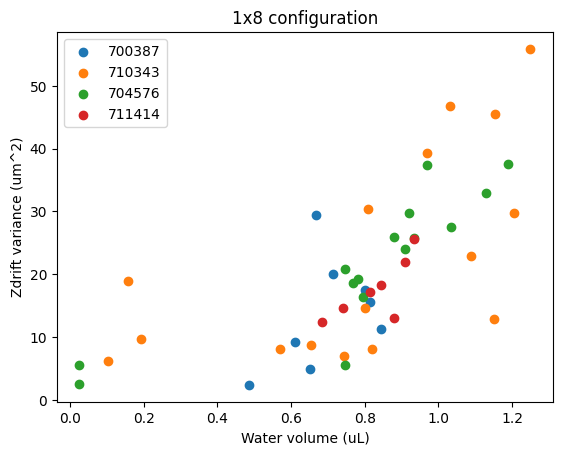

In [150]:
fig, ax = plt.subplots()
for mouse_id in mouse_ids:
    osids = np.intersect1d(lamf_table.query('mouse_id == @mouse_id').ophys_session_id.unique(), zdrift_osid)
    inds = np.where(np.isin(zdrift_osid, osids))[0]
    ax.scatter(water_volume_for_zdrift[inds], zdrift_spread[inds], label=mouse_id)
ax.legend()
ax.set_xlabel('Water volume (uL)')
ax.set_ylabel('Zdrift variance (um^2)')
ax.set_title('1x8 configuration')

### 2x4 configuration

Text(0.5, 1.0, '2x4 configuration')

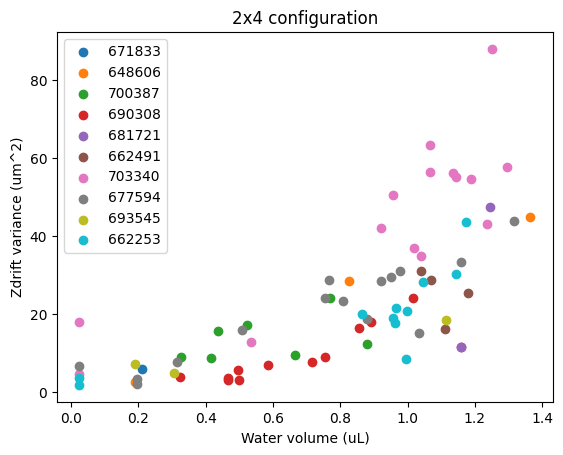

In [158]:
# Getting relevant osids
zdrift_test_table = zdrift_run_table.groupby('ophys_session_id').apply(lambda x: len(x.targeted_structure.unique())==2)
osids = zdrift_test_table[zdrift_test_table].index.values

# getting water uptake records (filtering osid based on the record existence)
water_recorded_osid = []
water_volume = []
for osid in osids:
    session = mongo.qc.metrics.find_one({'lims_id': int(osid)})
    if 'change_detection' in session.keys():
        try:
            if 'total_water' in session['change_detection'].keys():
                total_water = session['change_detection']['total_water']
                earned_water = session['change_detection']['earned_water']
            else:
                total_water = session['change_detection']['behavior_stats'][0]['total_water']
                earned_water = session['change_detection']['behavior_stats'][0]['earned_water']
            if 'OPHYS_6_' in lamf_table.query('ophys_session_id == @osid').session_type.unique()[0]:
                water_volume.append(total_water - earned_water)
            else:
                water_volume.append(total_water)
            water_recorded_osid.append(osid)
        except:
            pass
assert len(water_recorded_osid) == len(water_volume)

# getting z-drift spread
# Variance
zdrift_spread = []
num_opids = []
zdrift_osid = []
for osid in water_recorded_osid:
    try:
        corrcoef, matched_plane_indices, _ = get_zdrift_results_first_last(osid, load_dir)
        if len(np.where(np.array(corrcoef) < 0.7)[0]) > 0:
            continue
        zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
        num_opids.append(len(zdrift_session))
        zdrift_spread.append(zdrift_session.var())
        zdrift_osid.append(osid)
    except:
        pass

water_volume_for_zdrift = []
for osid in zdrift_osid:
    water_volume_for_zdrift.append(water_volume[water_recorded_osid.index(osid)])
zdrift_osid = np.array(zdrift_osid)
water_volume_for_zdrift = np.array(water_volume_for_zdrift)
zdrift_spread = np.array(zdrift_spread)
mouse_ids = lamf_table.query('ophys_session_id in @zdrift_osid').mouse_id.unique()

fig, ax = plt.subplots()
for mouse_id in mouse_ids:
    osids = np.intersect1d(lamf_table.query('mouse_id == @mouse_id').ophys_session_id.unique(), zdrift_osid)
    inds = np.where(np.isin(zdrift_osid, osids))[0]
    ax.scatter(water_volume_for_zdrift[inds], zdrift_spread[inds], label=mouse_id)
ax.legend()
ax.set_xlabel('Water volume (uL)')
ax.set_ylabel('Zdrift variance (um^2)')
ax.set_title('2x4 configuration')

In [152]:
np.where(zdrift_spread > 150)

(array([10, 12, 13], dtype=int64),)

In [157]:
corrcoef

[[0.9064055145042692, 0.9325318169448283],
 [0.9024379396359248, 0.9320152224703281],
 [0.8826700441498261, 0.8945703320817124],
 [0.8927448803266106, 0.9254175868975205],
 [0.8724915778223405, 0.8624971433187474],
 [0.47474350075214916, 0.8710750132489837],
 [0.8943889017254825, 0.896442444763977],
 [0.8523516529005918, 0.8884246530834585]]

In [156]:
osid = zdrift_osid[10]
corrcoef, matched_plane_indices, _ = get_zdrift_results_first_last(osid, load_dir)
zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])

In [155]:
zdrift_session

array([ 11.25,  13.5 ,   0.75,   6.  ,  12.75, -33.  ,  16.5 ,   4.5 ])

# Save the table

In [35]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)
lamf_table = table.query('project_code == "LearningmFISHTask1A"')
lamf_table = lamf_table[~(lamf_table.session_type.str.contains("TRAINING_0_"))]
last_run_time = datetime(2024, 2, 28, 0, 0, 0)
zdrift_run_table =  lamf_table[lamf_table.apply(lambda x: pd.to_datetime(x.date_of_acquisition) < last_run_time, axis=1)]
zdrift_run_table.reset_index(drop=False, inplace=True)
keep_column_names = ['ophys_experiment_id', 'equipment_name', 'full_genotype',
                     'cre_line', 'indicator', 'ophys_session_id', 'project_code',
                     'imaging_depth', 'targeted_structure',
                     'date_of_acquisition', 'session_type']
zdrift_run_table = zdrift_run_table[keep_column_names]


In [36]:
def _assign_config(x):
    num_unique_regions = len(x.targeted_structure.unique())
    num_planes = len(x) / num_unique_regions
    if num_planes - int(round(num_planes)) != 0:
        num_planes = f'{num_planes:.1f}'
    else:
        num_planes = int(num_planes)
    x['config'] = f'{num_unique_regions}x{num_planes}'
    return x
zdrift_run_table = zdrift_run_table.groupby('ophys_session_id').apply(lambda x: _assign_config(x)).reset_index(drop=True)
zdrift_run_table.config.unique()

array(['2x4', '2x8', '2x7.5', '2x7', '2x6.5', '4x2', '1x2', '1x3', '2x2',
       '2x2.5', '2x3.5', '4x1.8', '4x1.5', '3x1.7', '3x2', '4x2.5',
       '4x2.2', '1x8', '1x9'], dtype=object)

In [31]:
zdrift_run_table.groupby('config').size()

config
1x2         6
1x3        15
1x8       304
1x9        18
2x2        16
2x2.5      10
2x3.5      56
2x4       776
2x6.5      13
2x7        70
2x7.5      15
2x8        96
3x1.7       5
3x2         6
4x1.5      12
4x1.8      21
4x2      1208
4x2.2       9
4x2.5     150
dtype: int64

In [37]:
zdrift_test_table = zdrift_run_table.query('config in ["1x8", "2x4"]')
len(zdrift_test_table)

1080

In [38]:
len(zdrift_test_table.ophys_session_id.unique())

135

In [33]:
osids = zdrift_test_table.ophys_session_id.unique()
osid = osids[0]
corrcoef_episodes, matched_plane_indices_episodes, oeids = get_zdrift_results(osid, load_dir)
corrcoef_fl, matched_plane_indices_fl, oeids = get_zdrift_results_first_last(osid, load_dir)

In [12]:
oeid = oeids[0]
depth, region = get_depth_region_from_db(oeid)

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [43]:
osids = zdrift_test_table.ophys_session_id.unique()
plane_zdrift_df = pd.DataFrame(columns=['oeid', 'depth', 'region', 'mpi_episodes', 'cc_episodes', 'mpi_fl', 'cc_fl'])
error_osids = []
for osid in osids:
    try:
        corrcoef_episodes, matched_plane_indices_episodes, oeids = get_zdrift_results(osid, load_dir)
        corrcoef_fl, matched_plane_indices_fl, oeids_fl = get_zdrift_results_first_last(osid, load_dir)
        assert (oeids == oeids_fl).all()
        for i, oeid in enumerate(oeids):
            depth, region = get_depth_region_from_db(oeid)
            temp_df = pd.DataFrame({'oeid': oeid, 'depth': depth, 'region': region,
                                    'mpi_episodes': [matched_plane_indices_episodes[i]],
                                    'cc_episodes': [corrcoef_episodes[i]],
                                    'mpi_fl': [matched_plane_indices_fl[i]],
                                    'cc_fl': [corrcoef_fl[i]]}, index=[0])
            plane_zdrift_df = pd.concat([plane_zdrift_df, temp_df], ignore_index=True)
    except:
        error_osids.append(osid)

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pan

In [44]:
error_osids

[1333716389, 1298214957, 1299986341, 1299452583, 1254734669, 1333714503]

In [46]:
zdrift_test_table

ophys_experiment_id equipment_name  \
0              1275171146         MESO.2   
1              1275171148         MESO.2   
2              1275171151         MESO.2   
3              1275171152         MESO.2   
4              1275171145         MESO.2   
...                   ...            ...   
2801           1259825184         MESO.1   
2802           1259825190         MESO.1   
2803           1259825187         MESO.1   
2804           1259825194         MESO.1   
2805           1259825182         MESO.1   

                                          full_genotype       cre_line  \
0     Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
1     Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
2     Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
3     Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
4     Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
...                                                 ...            ...   
2801  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
2802  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
2803  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
2804  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   
2805  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...  Gad2-IRES-Cre   

     indicator  ophys_session_id         project_code  imaging_depth  \
0      GCaMP7s        1275039517  LearningmFISHTask1A             71   
1      GCaMP7s        1275039517  LearningmFISHTask1A            371   
2      GCaMP7s        1275039517  LearningmFISHTask1A            271   
3      GCaMP7s        1275039517  LearningmFISHTask1A             71   
4      GCaMP7s        1275039517  LearningmFISHTask1A            265   
...        ...               ...                  ...            ...   
2801   GCaMP7s        1259364032  LearningmFISHTask1A            294   
2802   GCaMP7s        1259364032  LearningmFISHTask1A            262   
2803   GCaMP7s        1259364032  LearningmFISHTask1A            379   
2804   GCaMP7s        1259364032  LearningmFISHTask1A            354   
2805   GCaMP7s        1259364032  LearningmFISHTask1A            180   

     targeted_structure     date_of_acquisition         session_type config  
0                  VISp 2023-06-06 16:22:44.443  TRAINING_1_gratings    2x4  
1                  VISp 2023-06-06 16:22:44.443  TRAINING_1_gratings    2x4  
2                 VISam 2023-06-06 16:22:44.443  TRAINING_1_gratings    2x4  
3                 VISam 2023-06-06 16:22:44.443  TRAINING_1_gratings    2x4  
4                  VISp 2023-06-06 16:22:44.443  TRAINING_1_gratings    2x4  
...                 ...                     ...                  ...    ...  
2801               VISp 2023-04-03 16:27:41.544     OPHYS_6_images_B    2x4  
2802              VISam 2023-04-03 16:27:41.544     OPHYS_6_images_B    2x4  
2803               VISp 2023-04-03 16:27:41.544     OPHYS_6_images_B    2x4  
2804              VISam 2023-04-03 16:27:41.544     OPHYS_6_images_B    2x4  
2805               VISp 2023-04-03 16:27:41.544     OPHYS_6_images_B    2x4  

[1080 rows x 12 columns]

In [45]:
plane_zdrift_df

oeid depth region                      mpi_episodes  \
0     1275171148   371   VISp          [31, 33, 34, 35, 36, 39]   
1     1275171143   163   VISp          [27, 31, 33, 34, 36, 37]   
2     1275171152    71  VISam          [29, 31, 33, 35, 36, 41]   
3     1275171145   265   VISp          [30, 31, 32, 45, 45, 45]   
4     1275171146    71   VISp          [26, 28, 32, 33, 34, 35]   
...          ...   ...    ...                               ...   
1027  1259825182   180   VISp  [34, 36, 37, 38, 39, 39, 40, 39]   
1028  1259825187   379   VISp  [36, 35, 35, 36, 39, 39, 40, 39]   
1029  1259825184   294   VISp  [35, 34, 34, 36, 38, 38, 39, 38]   
1030  1259825194   354  VISam  [33, 33, 33, 34, 37, 38, 38, 39]   
1031  1259825191    93  VISam  [31, 32, 34, 36, 38, 39, 39, 40]   

                                            cc_episodes    mpi_fl  \
0     [0.8768556166206293, 0.8622728681245287, 0.865...  [29, 42]   
1     [0.8805471356973789, 0.8376754216254007, 0.850...  [24, 41]   
2     [0.8103952532916524, 0.8149027512391827, 0.822...  [24, 42]   
3     [0.8570002794762288, 0.856290283539191, 0.8401...  [27, 44]   
4     [0.8814019772733436, 0.8341259026862089, 0.836...  [26, 35]   
...                                                 ...       ...   
1027  [0.8823398756321197, 0.8096668900575845, 0.820...  [33, 39]   
1028  [0.866526420773805, 0.868996324033165, 0.88327...  [35, 39]   
1029  [0.9155071750810286, 0.9113533712590953, 0.915...  [34, 38]   
1030  [0.9291147141312438, 0.9323762119575356, 0.940...  [33, 39]   
1031  [0.9319459312188122, 0.9314938415557547, 0.935...  [30, 41]   

                                         cc_fl  
0      [0.854972648510691, 0.7993668147424484]  
1     [0.8704477670409961, 0.8763228700369714]  
2     [0.8140243999576189, 0.9004550552556044]  
3     [0.8473424176751275, 0.8408194646728513]  
4      [0.840161572346171, 0.8264307772975529]  
...                                        ...  
1027  [0.8979176688859544, 0.9127384769076885]  
1028  [0.8378972397034957, 0.9006521870080532]  
1029  [0.9146955284058458, 0.9129324109197129]  
1030   [0.9231894488004021, 0.922492521445899]  
1031  [0.9214591768812485, 0.9143861308312463]  

[1032 rows x 7 columns]

In [48]:
lamf_zdrift_table = plane_zdrift_df.merge(zdrift_test_table, left_on='oeid',
                                            right_on='ophys_experiment_id',
                                            how='inner')

In [49]:
lamf_zdrift_table

oeid depth region                      mpi_episodes  \
0     1275171148   371   VISp          [31, 33, 34, 35, 36, 39]   
1     1275171143   163   VISp          [27, 31, 33, 34, 36, 37]   
2     1275171152    71  VISam          [29, 31, 33, 35, 36, 41]   
3     1275171145   265   VISp          [30, 31, 32, 45, 45, 45]   
4     1275171146    71   VISp          [26, 28, 32, 33, 34, 35]   
...          ...   ...    ...                               ...   
1027  1259825182   180   VISp  [34, 36, 37, 38, 39, 39, 40, 39]   
1028  1259825187   379   VISp  [36, 35, 35, 36, 39, 39, 40, 39]   
1029  1259825184   294   VISp  [35, 34, 34, 36, 38, 38, 39, 38]   
1030  1259825194   354  VISam  [33, 33, 33, 34, 37, 38, 38, 39]   
1031  1259825191    93  VISam  [31, 32, 34, 36, 38, 39, 39, 40]   

                                            cc_episodes    mpi_fl  \
0     [0.8768556166206293, 0.8622728681245287, 0.865...  [29, 42]   
1     [0.8805471356973789, 0.8376754216254007, 0.850...  [24, 41]   
2     [0.8103952532916524, 0.8149027512391827, 0.822...  [24, 42]   
3     [0.8570002794762288, 0.856290283539191, 0.8401...  [27, 44]   
4     [0.8814019772733436, 0.8341259026862089, 0.836...  [26, 35]   
...                                                 ...       ...   
1027  [0.8823398756321197, 0.8096668900575845, 0.820...  [33, 39]   
1028  [0.866526420773805, 0.868996324033165, 0.88327...  [35, 39]   
1029  [0.9155071750810286, 0.9113533712590953, 0.915...  [34, 38]   
1030  [0.9291147141312438, 0.9323762119575356, 0.940...  [33, 39]   
1031  [0.9319459312188122, 0.9314938415557547, 0.935...  [30, 41]   

                                         cc_fl  ophys_experiment_id  \
0      [0.854972648510691, 0.7993668147424484]           1275171148   
1     [0.8704477670409961, 0.8763228700369714]           1275171143   
2     [0.8140243999576189, 0.9004550552556044]           1275171152   
3     [0.8473424176751275, 0.8408194646728513]           1275171145   
4      [0.840161572346171, 0.8264307772975529]           1275171146   
...                                        ...                  ...   
1027  [0.8979176688859544, 0.9127384769076885]           1259825182   
1028  [0.8378972397034957, 0.9006521870080532]           1259825187   
1029  [0.9146955284058458, 0.9129324109197129]           1259825184   
1030   [0.9231894488004021, 0.922492521445899]           1259825194   
1031  [0.9214591768812485, 0.9143861308312463]           1259825191   

     equipment_name                                      full_genotype  \
0            MESO.2  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
1            MESO.2  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
2            MESO.2  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
3            MESO.2  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
4            MESO.2  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
...             ...                                                ...   
1027         MESO.1  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
1028         MESO.1  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
1029         MESO.1  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
1030         MESO.1  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   
1031         MESO.1  Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...   

           cre_line indicator  ophys_session_id         project_code  \
0     Gad2-IRES-Cre   GCaMP7s        1275039517  LearningmFISHTask1A   
1     Gad2-IRES-Cre   GCaMP7s        1275039517  LearningmFISHTask1A   
2     Gad2-IRES-Cre   GCaMP7s        1275039517  LearningmFISHTask1A   
3     Gad2-IRES-Cre   GCaMP7s        1275039517  LearningmFISHTask1A   
4     Gad2-IRES-Cre   GCaMP7s        1275039517  LearningmFISHTask1A   
...             ...       ...               ...                  ...   
1027  Gad2-IRES-Cre   GCaMP7s        1259364032  LearningmFISHTask1A   
1028  Gad2-IRES-Cre   GCaMP7s        1259364032  LearningmFI

In [21]:
water_recorded_osid

[]

In [42]:
lamf_zdrift_table['ophys_session_id'].unique()

array([1275039517, 1275235423, 1275444391, 1275743689, 1328177343,
       1328518742, 1327887497, 1329068892, 1329565632, 1328827878,
       1330149196, 1330357185, 1330660575, 1333363667, 1331164473,
       1331788264, 1332498813, 1332300891, 1332789629, 1330991697,
       1296375824, 1296101170, 1296630484, 1296851410, 1297645240,
       1298664530, 1300206865, 1298434214, 1300441205, 1289008496,
       1288745071, 1289930478, 1290486915, 1291730361, 1290764503,
       1290988505, 1291986206, 1292661041, 1292415143, 1293244056,
       1293467852, 1256016900, 1254374184, 1256313839, 1256839013,
       1256562528, 1326437510, 1325702798, 1325496014, 1325954010,
       1326197073, 1327350251, 1326968345, 1328512625, 1327146245,
       1327592860, 1327858060, 1328804699, 1329555156, 1318307740,
       1315367383, 1315610616, 1315948257, 1316158004, 1316379702,
       1316967819, 1317164333, 1317413890, 1317628827, 1317839158,
       1318473952, 1318738409, 1319143300, 1318954288, 1319380

In [40]:
lamf_zdrift_table['ophys_session_id'] = lamf_zdrift_table['ophys_session_id'].apply(lambda x: int(x))

In [43]:
# get the water information
lamf_zdrift_table['ophys_session_id'] = lamf_zdrift_table['ophys_session_id'].apply(lambda x: int(x))
osids = lamf_zdrift_table.ophys_session_id.unique()
water_recorded_osid = []
no_water_record_osid = []
water_volume = []
for osid in osids:
    session = mongo.qc.metrics.find_one({'lims_id': int(osid)})
    if 'change_detection' in session.keys():
        try:
            if 'total_water' in session['change_detection'].keys():
                total_water = session['change_detection']['total_water']
                earned_water = session['change_detection']['earned_water']
            else:
                total_water = session['change_detection']['behavior_stats'][0]['total_water']
                earned_water = session['change_detection']['behavior_stats'][0]['earned_water']
            if 'OPHYS_6_' in lamf_table.query('ophys_session_id == @osid').session_type.unique()[0]:
                water_volume.append(total_water - earned_water)
            else:
                water_volume.append(total_water)
            water_recorded_osid.append(osid)
        except:
            no_water_record_osid.append(osid)
assert len(water_recorded_osid) == len(water_volume)

In [44]:
no_water_record_osid

[]

In [46]:
for i, osid in enumerate(water_recorded_osid):
    lamf_zdrift_table.loc[lamf_zdrift_table.ophys_session_id==osid, 'water'] = water_volume[i]

In [47]:
# # save the table
# zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
# save_fn = zdrift_dir/'multiplane_zdrift_lamf.pkl'
# lamf_zdrift_table.to_pickle(save_fn)

In [34]:
zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
load_fn = zdrift_dir/'multiplane_zdrift_lamf.pkl'
lamf_zdrift_table = pd.read_pickle(load_fn)

In [36]:
lamf_zdrift_table[lamf_zdrift_table.ophys_session_id.isna()]

Empty DataFrame
Columns: [oeid, depth, region, mpi_episodes, cc_episodes, mpi_fl, cc_fl, ophys_experiment_id, equipment_name, full_genotype, cre_line, indicator, ophys_session_id, project_code, imaging_depth, targeted_structure, date_of_acquisition, session_type, config, water]
Index: []

# More simulations for paired correction
- Proportion of failure due to z-drift, if paired as now (inner pairs + outer pairs)
- Porportion of failure due to z-drift, if paired between close-by planes

0.21341463414634146

0.049796747967479675

# Error cases
- ophys_container_id issue

In [35]:
osid = 1317188386
from_lims.get_ophys_container_ids_for_ophys_session_id(osid) 

ophys_container_id
0          1317488271
1          1317488268
2          1317488265
3          1317488280

In [42]:
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
osid = 1197680039
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
for oeid in oeids:
    matched_plane_indices, corrcoef, segment_reg_imgs, \
        ref_oeid, ref_zstack_crop, rigid_tmat_list, translation_shift_list, ops = \
            dem.get_experiment_zdrift(oeid, ref_oeid=oeid, save_dir=save_dir, rerun=True)


In [43]:
osid = 1300206865
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
oeids

array([1300329813, 1300329815, 1300329821, 1300329812, 1300329810,
       1300329819, 1300329818, 1300329816], dtype=int64)

In [45]:
oeid

1300329812

In [47]:
print(from_lims.get_session_h5_filepath(osid))

\\allen\programs\mindscope\production\learning\prod0\specimen_1287205163\ophys_session_1300206865\1300206865_20230928T111704.h5


In [44]:
for oeid in oeids:
    from_lims.get_dff_traces_filepath(oeid)

KeyError: 'filepath'

In [40]:
from importlib import reload
reload(dem)

<module 'brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module' from 'c:\\users\\jinho.kim\\github\\brain_observatory_qc\\brain_observatory_qc\\pipeline_dev\\scripts\\depth_estimation_module.py'>

In [34]:
oeid

1319312444

In [37]:
# read json file
import json
json_filepath = from_lims.get_platform_json_filepath(osid)
with open(json_filepath, 'r') as f:
    data = json.load(f)
data['rig_id']

In [42]:
reload(dem)
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
matched_plane_indices, corrcoef, segment_reg_imgs, \
    ref_oeid, ref_zstack_crop, rigid_tmat_list, translation_shift_list, ops = \
        dem.get_experiment_zdrift(oeid, ref_oeid=oeid, save_dir=save_dir, rerun=True)

In [30]:
print(from_lims.get_dff_traces_filepath(oeid).parent)

\\allen\programs\mindscope\production\learning\prod0\specimen_1302006161\ophys_session_1319182745\ophys_experiment_1319312444


In [26]:
for oeid in oeids:
    from_lims.get_general_info_for_ophys_experiment_id(oeid)

KeyError: 'specimen_storage_directory'